# Compare vaccination strategies. $e$=0.7

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS

mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
taus = EXPERIMENTS['taus']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']
e = EPIDEMIC['e']
strategies = EXPERIMENTS['strategies']

# Plot parameters
plot_interval = 10
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']
color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

In [3]:
exp_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=init_vacc,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0,
                                      e=e,
                                      taus=taus)

Beginning experiments.
Parameters:
Number of age ervas: 5.
Number of age groups: 9.
Number of vaccines per day: 30000.
t0: 2021-04-18.
T: 115.
Vaccine efficacy (e): 0.7.
Rs to try: [0.75, 1.0, 1.25, 1.5].
Taus to try: [0, 0.5, 1.0].
Initialize with vaccinated people: True.
Strategies:
[([1, 0, 0], 'Pop only'), ([0, 0, 0], 'No vaccination'), ([0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'Pop, Inf and Hosp'), ([0.5, 0, 0.5], 'Pop and Hosp'), ([0.5, 0.5, 0], 'Pop and Inf'), ([0, 0.5, 0.5], 'Hosp and Inf'), ([0, 0, 1], 'Hosp only'), ([0, 1, 0], 'Inf only'), (None, 'Optimal')].

Running 108 experiments with 4 CPUS.
Start (12420). Exp: 1. R: 0.75. tau: 0. Policy: Pop onlyStart (12423). Exp: 4. R: 0.75. tau: 0. Policy: Pop and HospStart (12422). Exp: 3. R: 0.75. tau: 0. Policy: Pop, Inf and HospStart (12421). Exp: 2. R: 0.75. tau: 0. Policy: No vaccination



Finished (12422). Exp: 3. Elapsed: 0:00:06.923803
Start (12422). Exp: 5. R: 0.75. tau: 0. Policy: Pop and Inf
Finished

Start (12422). Exp: 60. R: 1.25. tau: 0.5. Policy: Hosp and Inf
Finished (12421). Exp: 57. Elapsed: 0:00:05.888355
Start (12421). Exp: 61. R: 1.25. tau: 0.5. Policy: Hosp only
Finished (12420). Exp: 58. Elapsed: 0:00:05.873027
Start (12420). Exp: 62. R: 1.25. tau: 0.5. Policy: Inf only
Finished (12423). Exp: 59. Elapsed: 0:00:05.948709
Start (12423). Exp: 63. R: 1.25. tau: 0.5. Policy: Optimal
Finished (12422). Exp: 60. Elapsed: 0:00:06.627595
Start (12422). Exp: 91. R: 1.25. tau: 1.0. Policy: Pop only
Finished (12421). Exp: 61. Elapsed: 0:00:06.686223
Start (12421). Exp: 92. R: 1.25. tau: 1.0. Policy: No vaccination
Finished (12420). Exp: 62. Elapsed: 0:00:06.715064
Start (12420). Exp: 93. R: 1.25. tau: 1.0. Policy: Pop, Inf and Hosp
Finished (12423). Exp: 63. Elapsed: 0:00:06.611944
Start (12423). Exp: 94. R: 1.25. tau: 1.0. Policy: Pop and Hosp
Finished (12422). Exp: 91. Elapsed: 0:00:05.901253
Start (12422). Exp: 95. R: 1.25. tau: 1.0. Policy: Pop and Inf
Finished (12421). Exp: 92.

In [10]:
def plot_results(ax, r, tau, metric, exp_results, T, erva, ervas_labels, plot_interval,
                 baseline='Pop only', skip_no_vacc=True, offset=15, long_title=True, out_sort=True):
    try:
        erva_idx = ervas_labels.index(erva)
    except ValueError:
        if erva == 'Finland':
            erva_idx = -1
        else:
            raise ValueError('Wrong ERVA selected')
    
    x = np.arange(T)
    x = x[offset:]

    results = exp_results[r][tau]
    baseline_all_time = None
    for label, label_level in results.items():
        if label == baseline:
            baseline_results = label_level['results'][metric]
            # Sum across all age groups
            baseline_all_time = baseline_results.sum(axis=0)
            if erva_idx == -1:
                # Sum across all ERVAs
                baseline_all_time = baseline_all_time.sum(axis=0)
            else:
                baseline_all_time = baseline_all_time[erva_idx, :]
            baseline_all_time = baseline_all_time[offset:]
    
    assert baseline_all_time is not None
    assert baseline_all_time.shape[0] == len(x)
    
    totals = []
    label_i = 0
    for label, label_level in results.items():
        if label == baseline:
            continue

        if label == 'No vaccination' and skip_no_vacc:
            continue
            
        metric_results = label_level['results'][metric]
        # Sum across all age groups
        metric_all_time = metric_results.sum(axis=0)
        if erva_idx == -1:
            # Sum across all ERVAs
            metric_all_time = metric_all_time.sum(axis=0)
        else:
            metric_all_time = metric_all_time[erva_idx, :]
        metric_all_time = metric_all_time[offset:]
        
        assert metric_all_time.shape[0] == len(x)
        
        plot_metric = metric_all_time/baseline_all_time
        plot_metric = np.nan_to_num(plot_metric, nan=1)
        plot_metric = plot_metric - 1
        plot_metric = plot_metric*100
        
        color = label_i % len(color_palette)
        ax.plot(x, plot_metric, label=label, color=color_palette[color])
        
        baseline_policy = baseline_all_time.sum(axis=0)
        total_policy = metric_all_time.sum(axis=0)
        rel_total = ((total_policy/baseline_policy)-1)*100
        total = (label, rel_total)
        totals.append(total)
        label_i += 1
    
    if out_sort:
        sorted_totals = sorted(totals, key=lambda x: x[-1])
        for total in sorted_totals:
            print('%s: %s' % (total[0], total[1]))
        
    ax.set_xlabel('Days after start time')
    ax.set_ylabel('Relative change in {0} (\%)'.format(metric))
    if long_title:
        ax.set_title('Relative change of %s in %s compared to %s.\n R=%s. tau=%s' % (metric, erva, baseline, r, tau))
    else:
        ax.set_title('%s' % (erva, ))
    ax.legend()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(plot_interval))
        
    return ax

# Deaths

Optimal: -2.899945289924888
Pop and Inf: 0.4830229545703668
Pop and Hosp: 0.8287193696859152
Pop, Inf and Hosp: 1.3647151131941593
Inf only: 2.7470124828532505
Hosp and Inf: 3.0737390304681256
Hosp only: 3.441604955611699


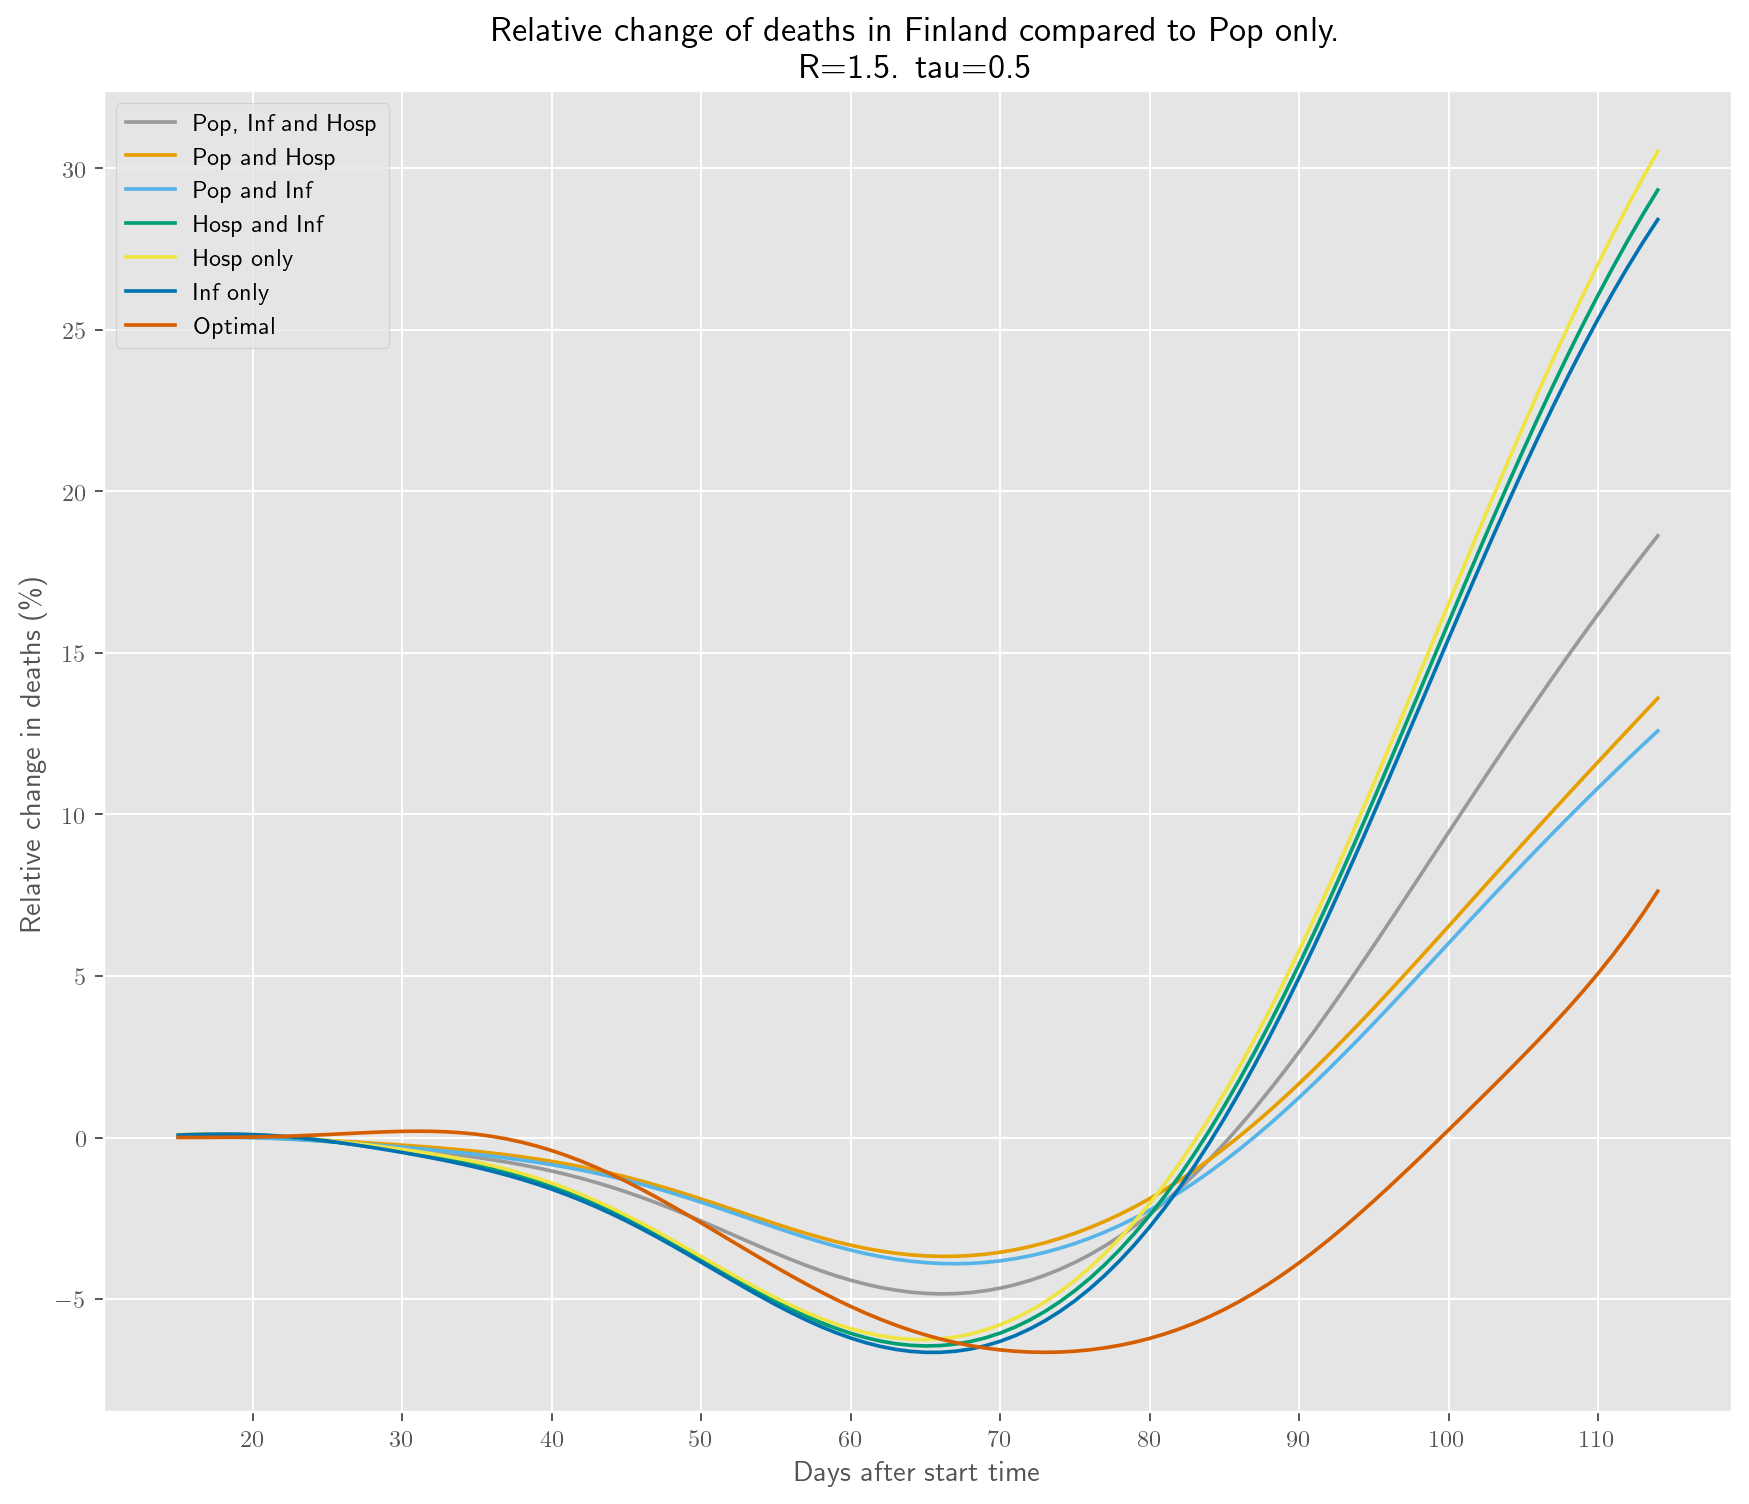

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_results(ax, r=1.5, tau=0.5, metric='deaths', exp_results=exp_results, T=T,
                  erva='Finland', ervas_labels=ervas_labels, plot_interval=plot_interval)

# Hospitalizations

Optimal: -0.7870075314378333
Pop and Inf: 0.8394505073879843
Pop and Hosp: 1.2915790618507117
Pop, Inf and Hosp: 2.4474181934449613
Inf only: 5.718648642916779
Hosp and Inf: 6.137320690379311
Hosp only: 6.690582386225441


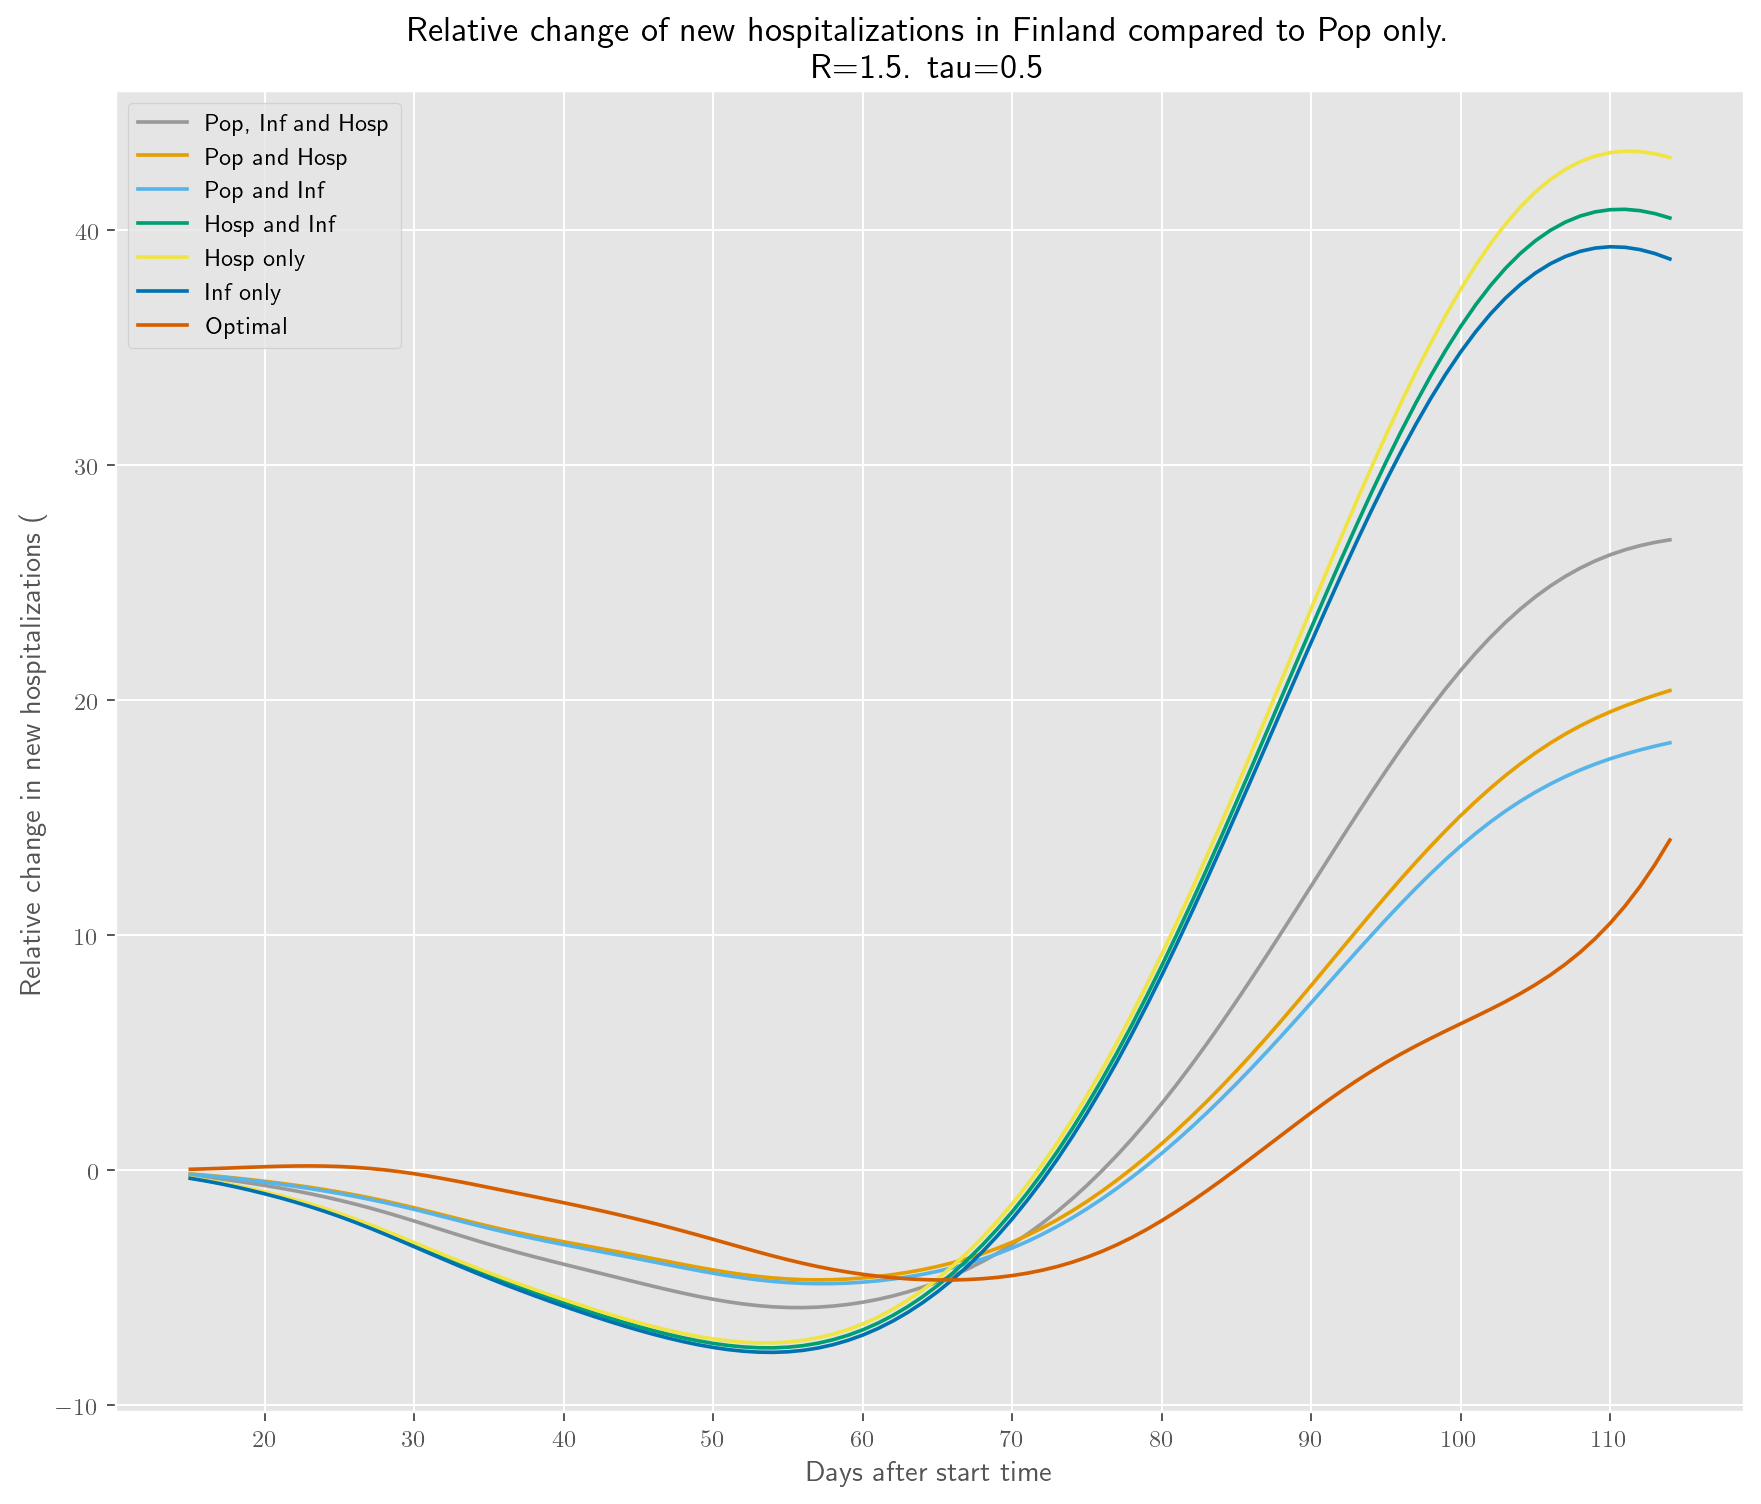

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_results(ax, r=1.5, tau=0.5, metric='new hospitalizations', exp_results=exp_results, T=T,
                  erva='Finland', ervas_labels=ervas_labels, plot_interval=plot_interval)

# Infections

Optimal: -2.9799487226882526
Pop and Inf: 0.20744665449008437
Pop and Hosp: 0.5869227254470699
Pop, Inf and Hosp: 0.8715170992234178
Inf only: 1.268551576273791
Hosp and Inf: 1.7209434044867633
Hosp only: 2.1969944495902505


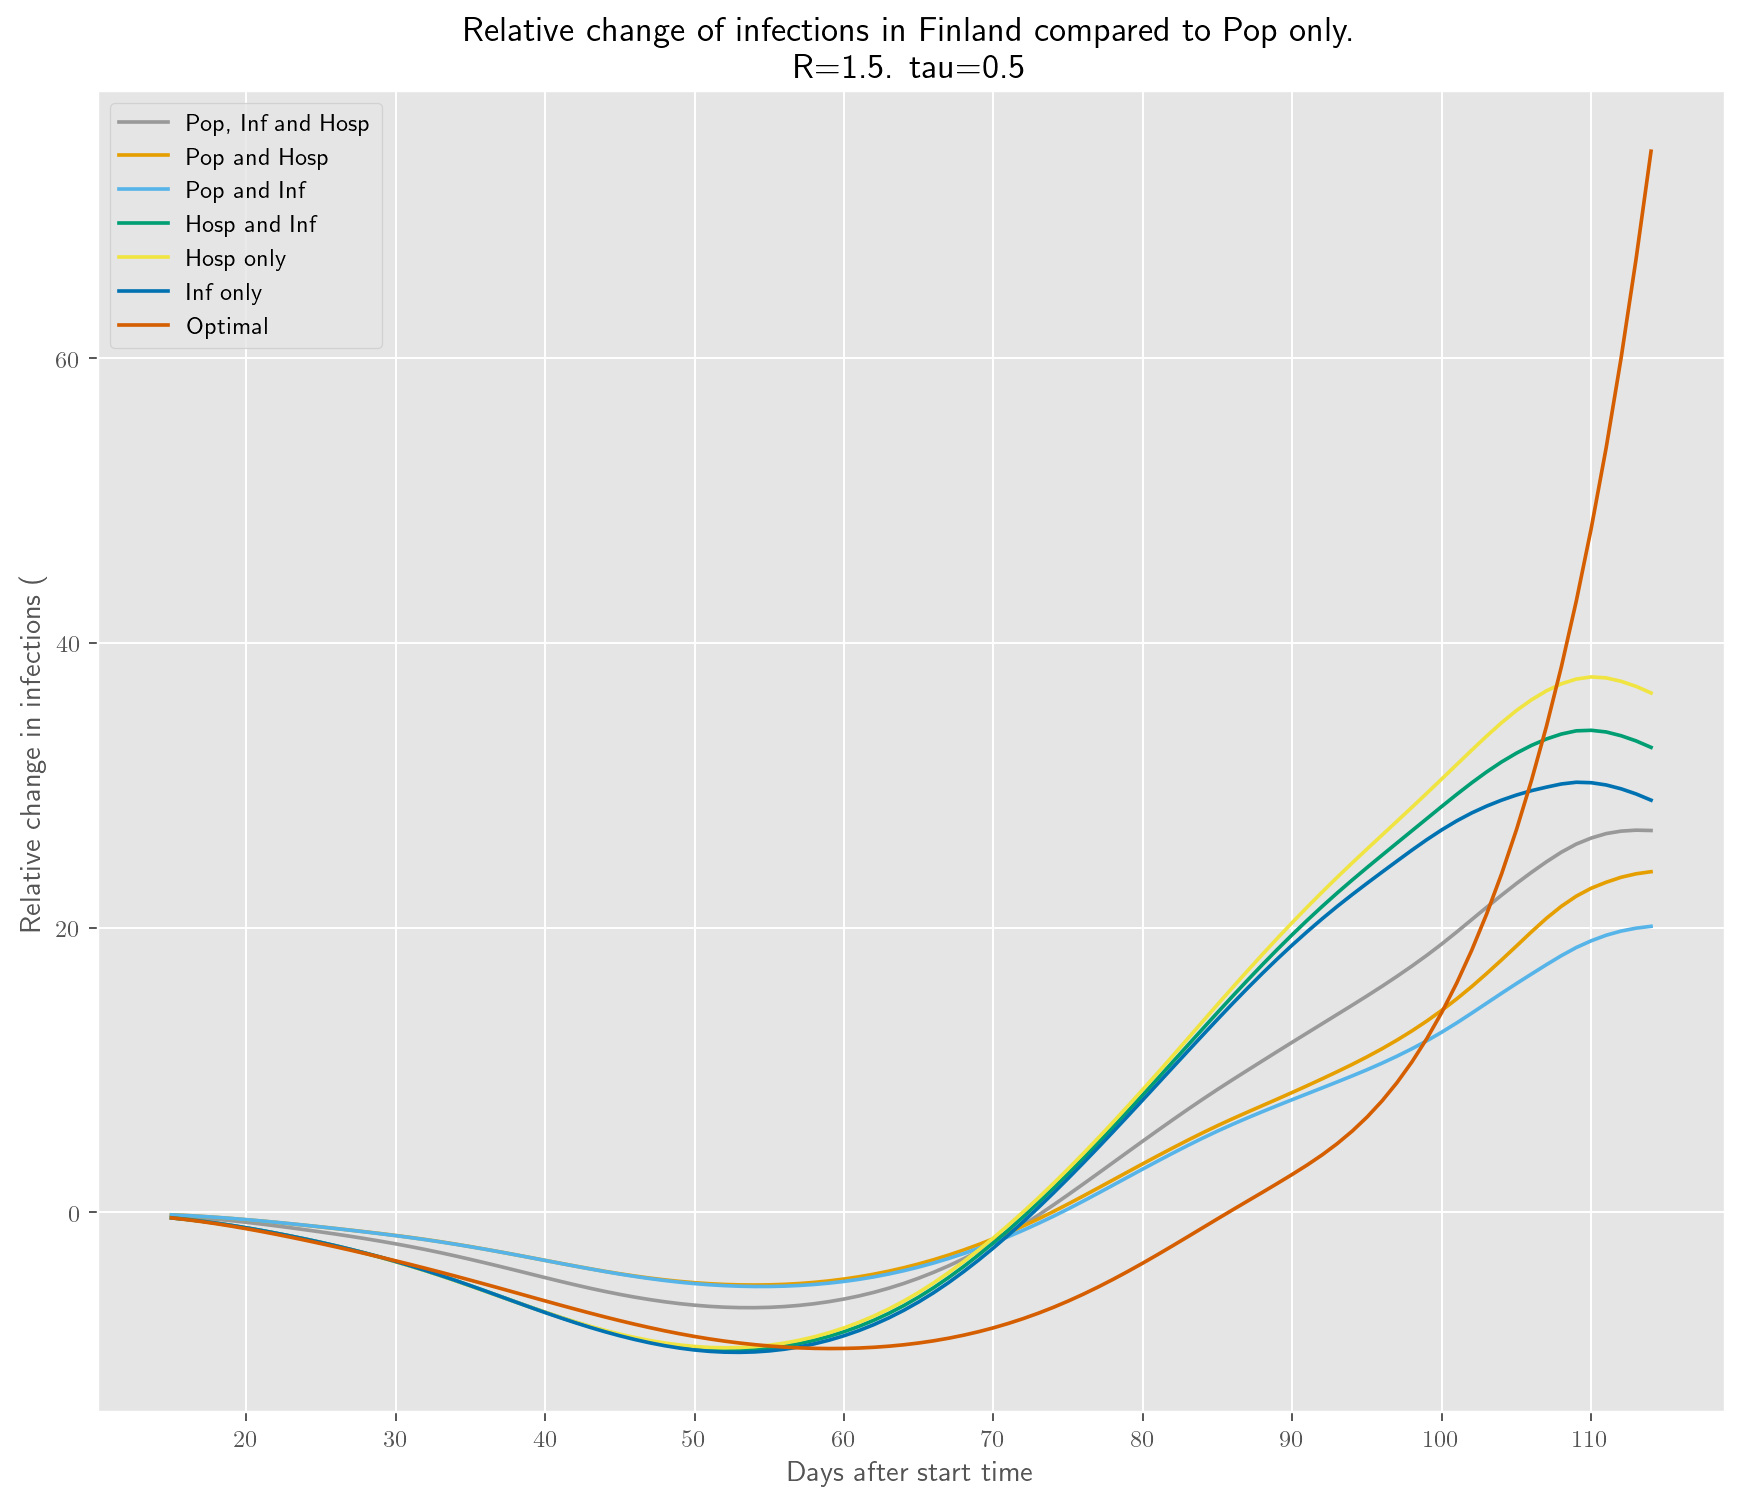

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_results(ax, r=1.5, tau=0.5, metric='infections', exp_results=exp_results, T=T,
                  erva='Finland', ervas_labels=ervas_labels, plot_interval=plot_interval)

# Saving figures and generating latex

In [8]:
def save_and_generate_latex(r_experiments, taus, ervas_labels, metrics, exp_results, skip_no_vacc, out_sort, dpis,
                            offset, long_title, T, img_dir, plot_interval, baseline, file_format, latex_template):
    os.makedirs(img_dir, exist_ok=True)
    plot_ervas = ['Finland']+ ervas_labels
    for r in r_experiments:
        for tau in taus:
            for metric in metrics:
                fig, axs = plt.subplots(3, 2,
                                        sharex=True,
                                        figsize=(11, 12))
                axs = axs.flat
                for erva, ax in zip(plot_ervas, axs):
                    ax = plot_results(ax, r=r, tau=tau, metric=metric, exp_results=exp_results, T=T,
                                      erva=erva, ervas_labels=ervas_labels, long_title=long_title,
                                      skip_no_vacc=skip_no_vacc, offset=offset, plot_interval=plot_interval,
                                      baseline=baseline, out_sort=out_sort)
                    handles, labels = ax.get_legend_handles_labels()
                    ax.get_legend().remove()
                    x_lab = ax.get_xlabel()
                    ax.set_xlabel('')
                    y_lab = ax.get_ylabel()
                    ax.set_ylabel('')
                fig.suptitle('Relative change in %s wrt strategy %s.\n $R_0=%s. \\tau=%s$' % (metric, baseline, r, tau))
                fig.text(0.5, 0.04, x_lab, ha='center')
                fig.text(0.04, 0.5, y_lab, va='center', rotation='vertical')
                fig.legend(handles, labels, loc='upper right', framealpha=0.5)
                name = 'r%s_tau%s_metric_%s' % (r, tau, metric)
                fig_name = name + '.' + file_format 
                fig_path = os.path.join(img_dir, fig_name)
                fig.savefig(fig_path, format=file_format, dpi=dpis, bbox_inches='tight')
                
                latext_text = latex_template.format(fig_name=fig_name,
                                                    metric=metric,
                                                    baseline=baseline,
                                                    name=name,
                                                    r=r,
                                                    tau=tau)
                print(latext_text)
                
                


    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/r0.75_tau0.5_metric_deaths.pdf}
      \caption{Relative change in deaths for all vaccination strategies with respect to vaccination strategy Pop only.
      For this scenario, the basic reproduction number $R_0 = 0.75$ and the mobility value $\tau = 0.5$.
      Upper left: Finland, upper right: HYKS, middle left: TYKS, middle right: TAYS, lower left: KYS, lower right: OYS.}
      \label{fig:r0.75_tau0.5_metric_deaths}
    \end{figure}


    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/r0.75_tau0.5_metric_new hospitalizations.pdf}
      \caption{Relative change in new hospitalizations for all vaccination strategies with respect to vaccination strategy Pop only.
      For this scenario, the basic reproduction number $R_0 = 0.75$ and the mobility value $\tau = 0.5$.
      Upper left: Finland, upper right: HYKS, middle left: TYKS, middle right: TAYS, lower left: KYS, lowe

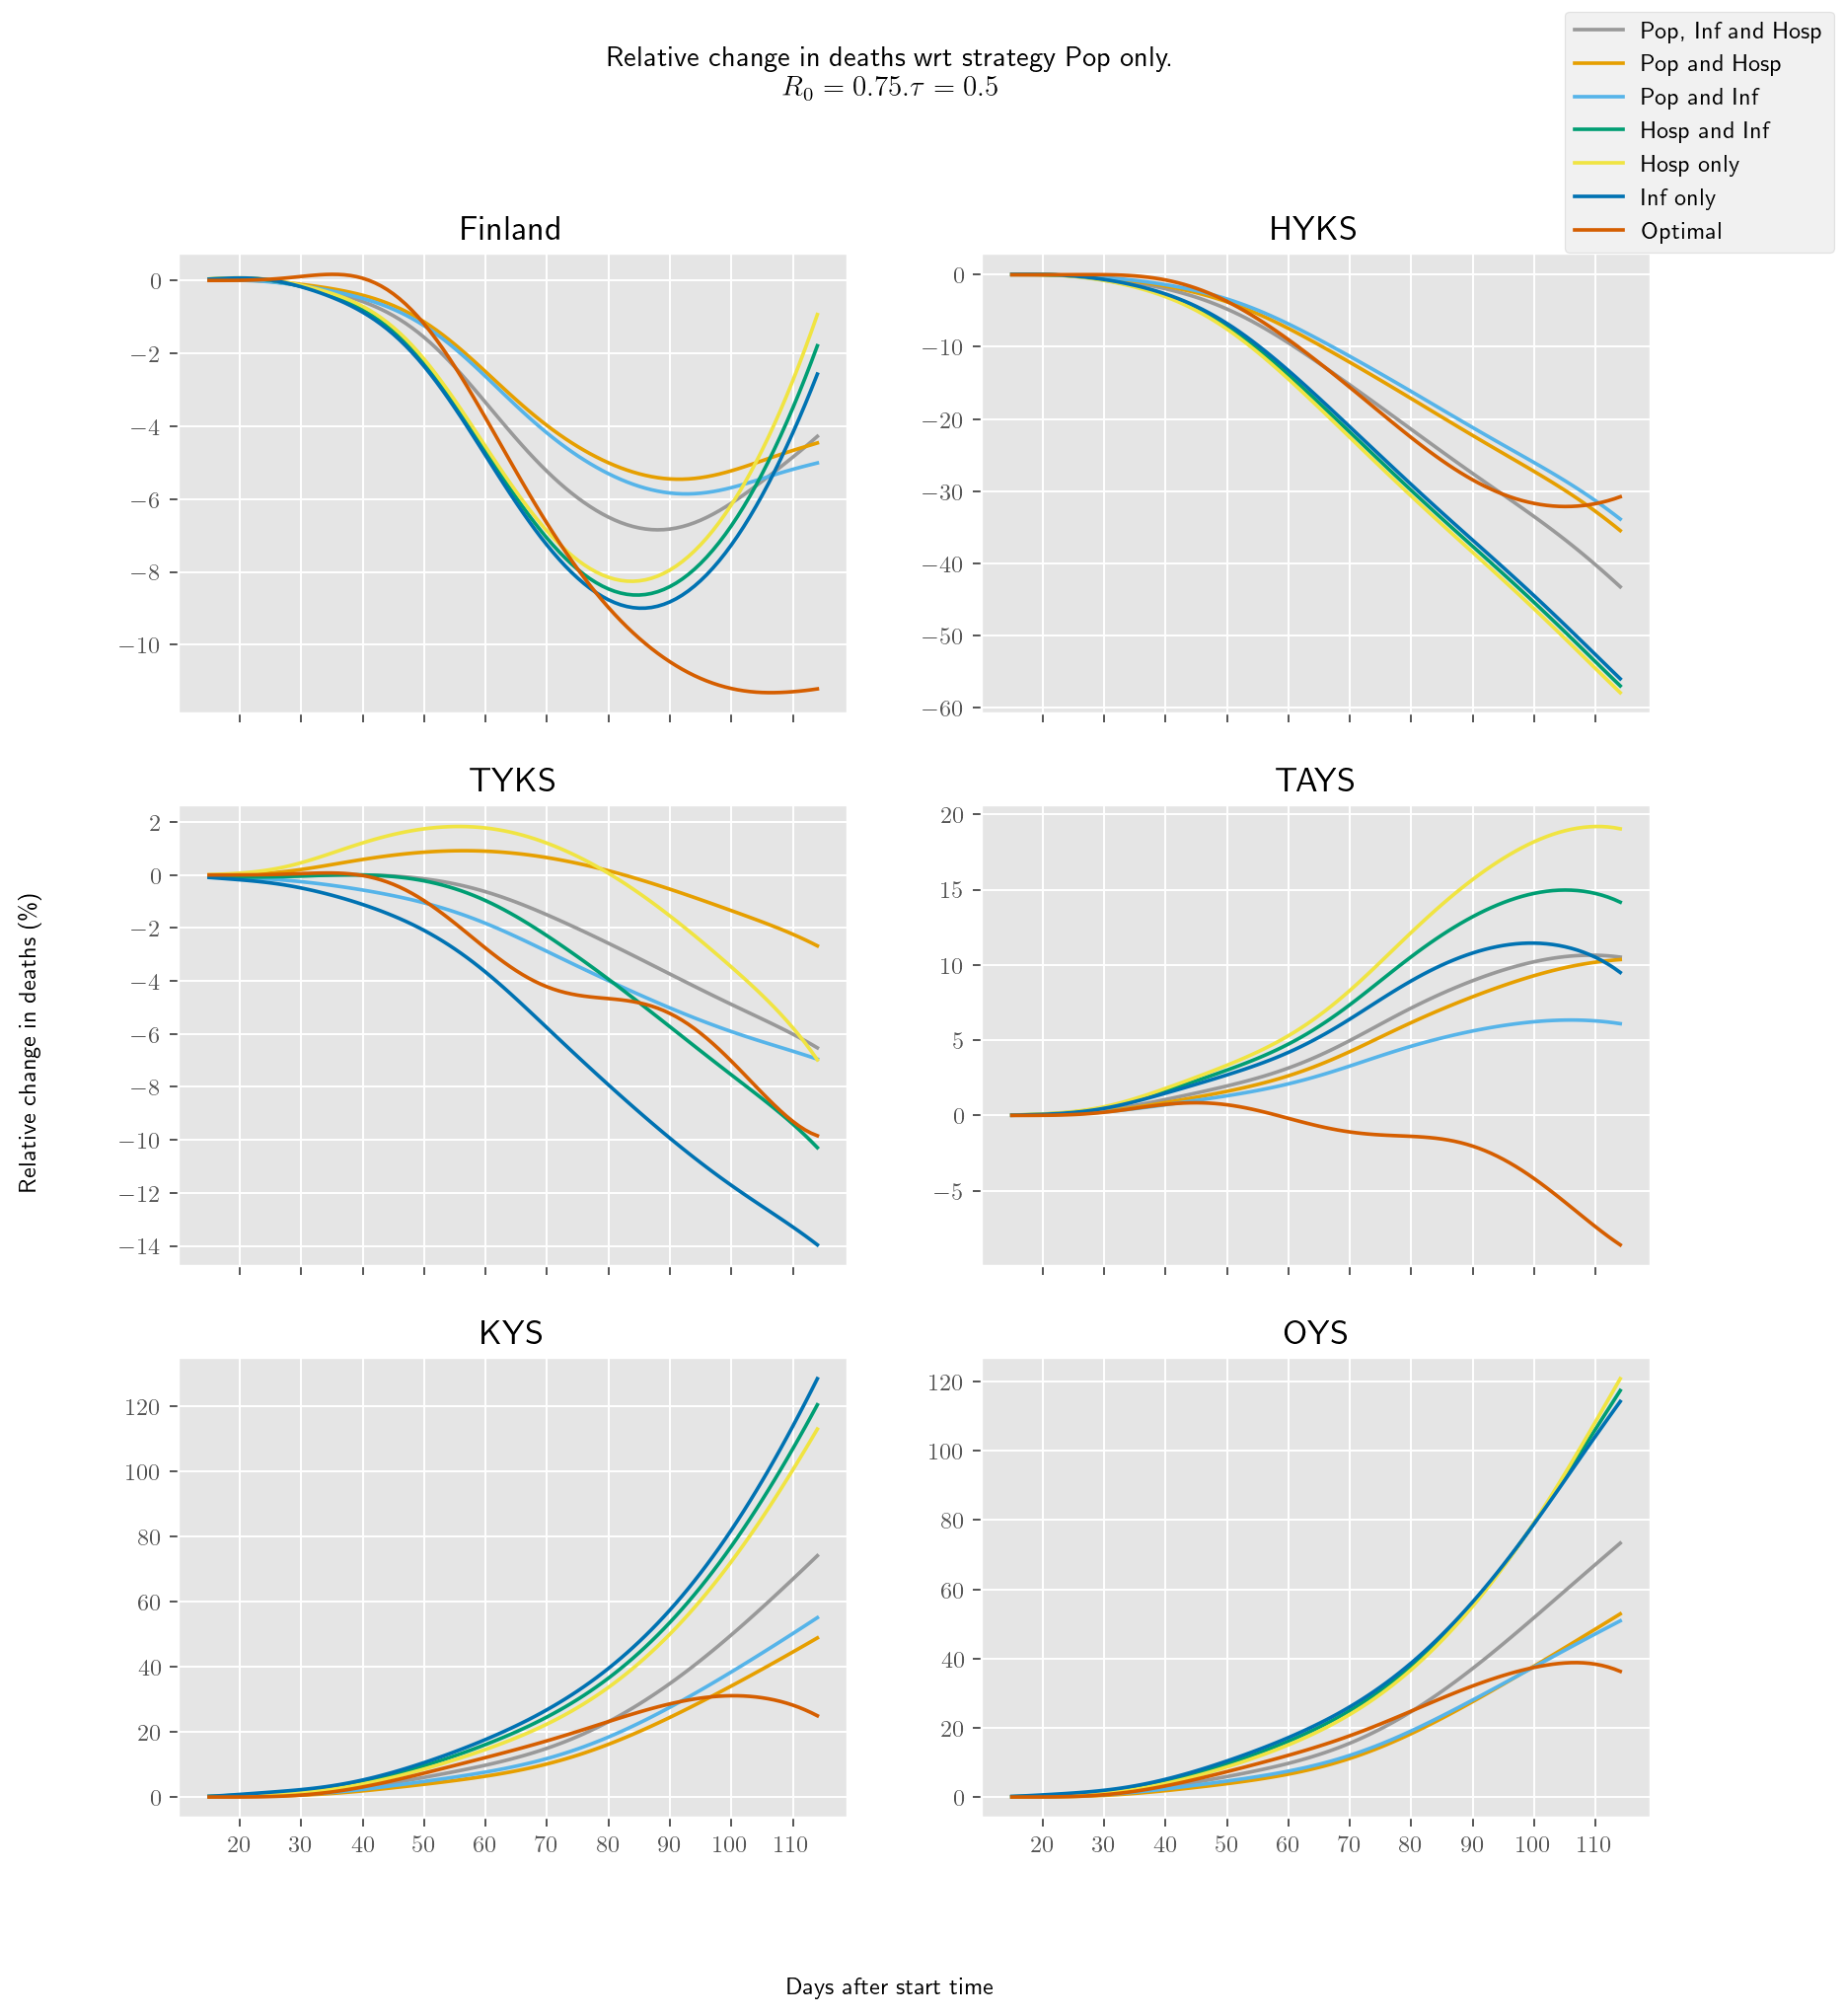

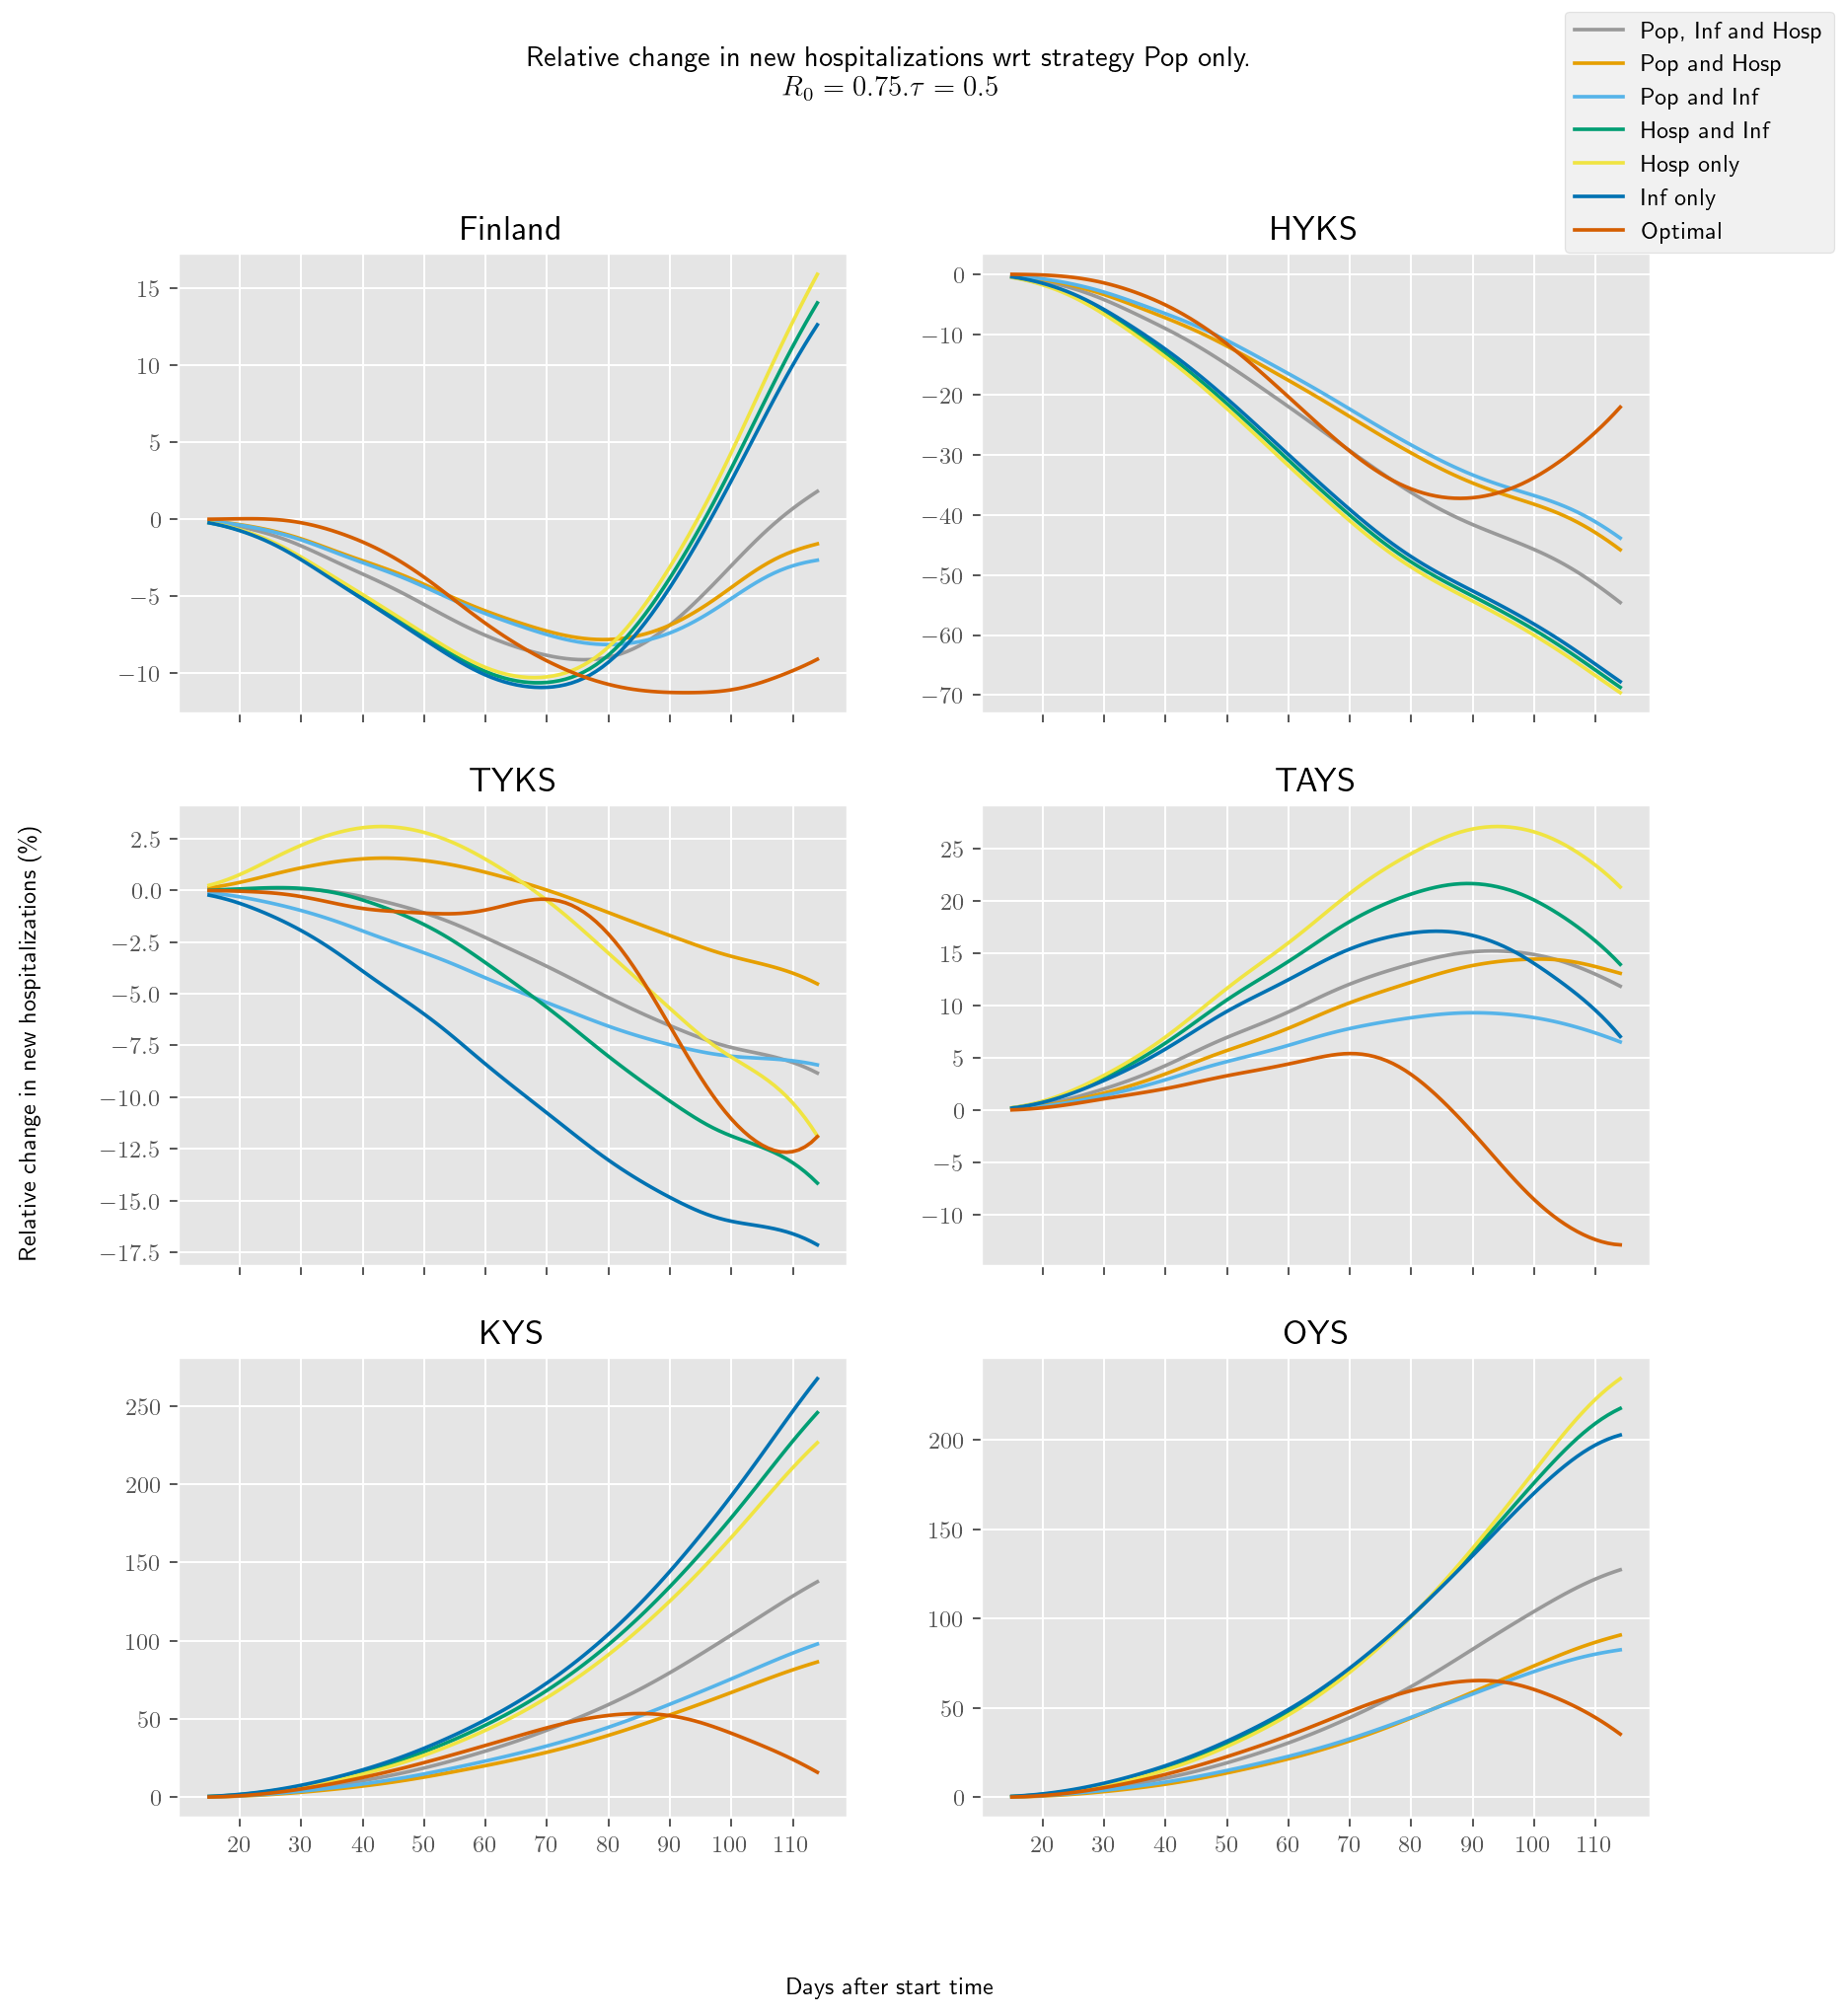

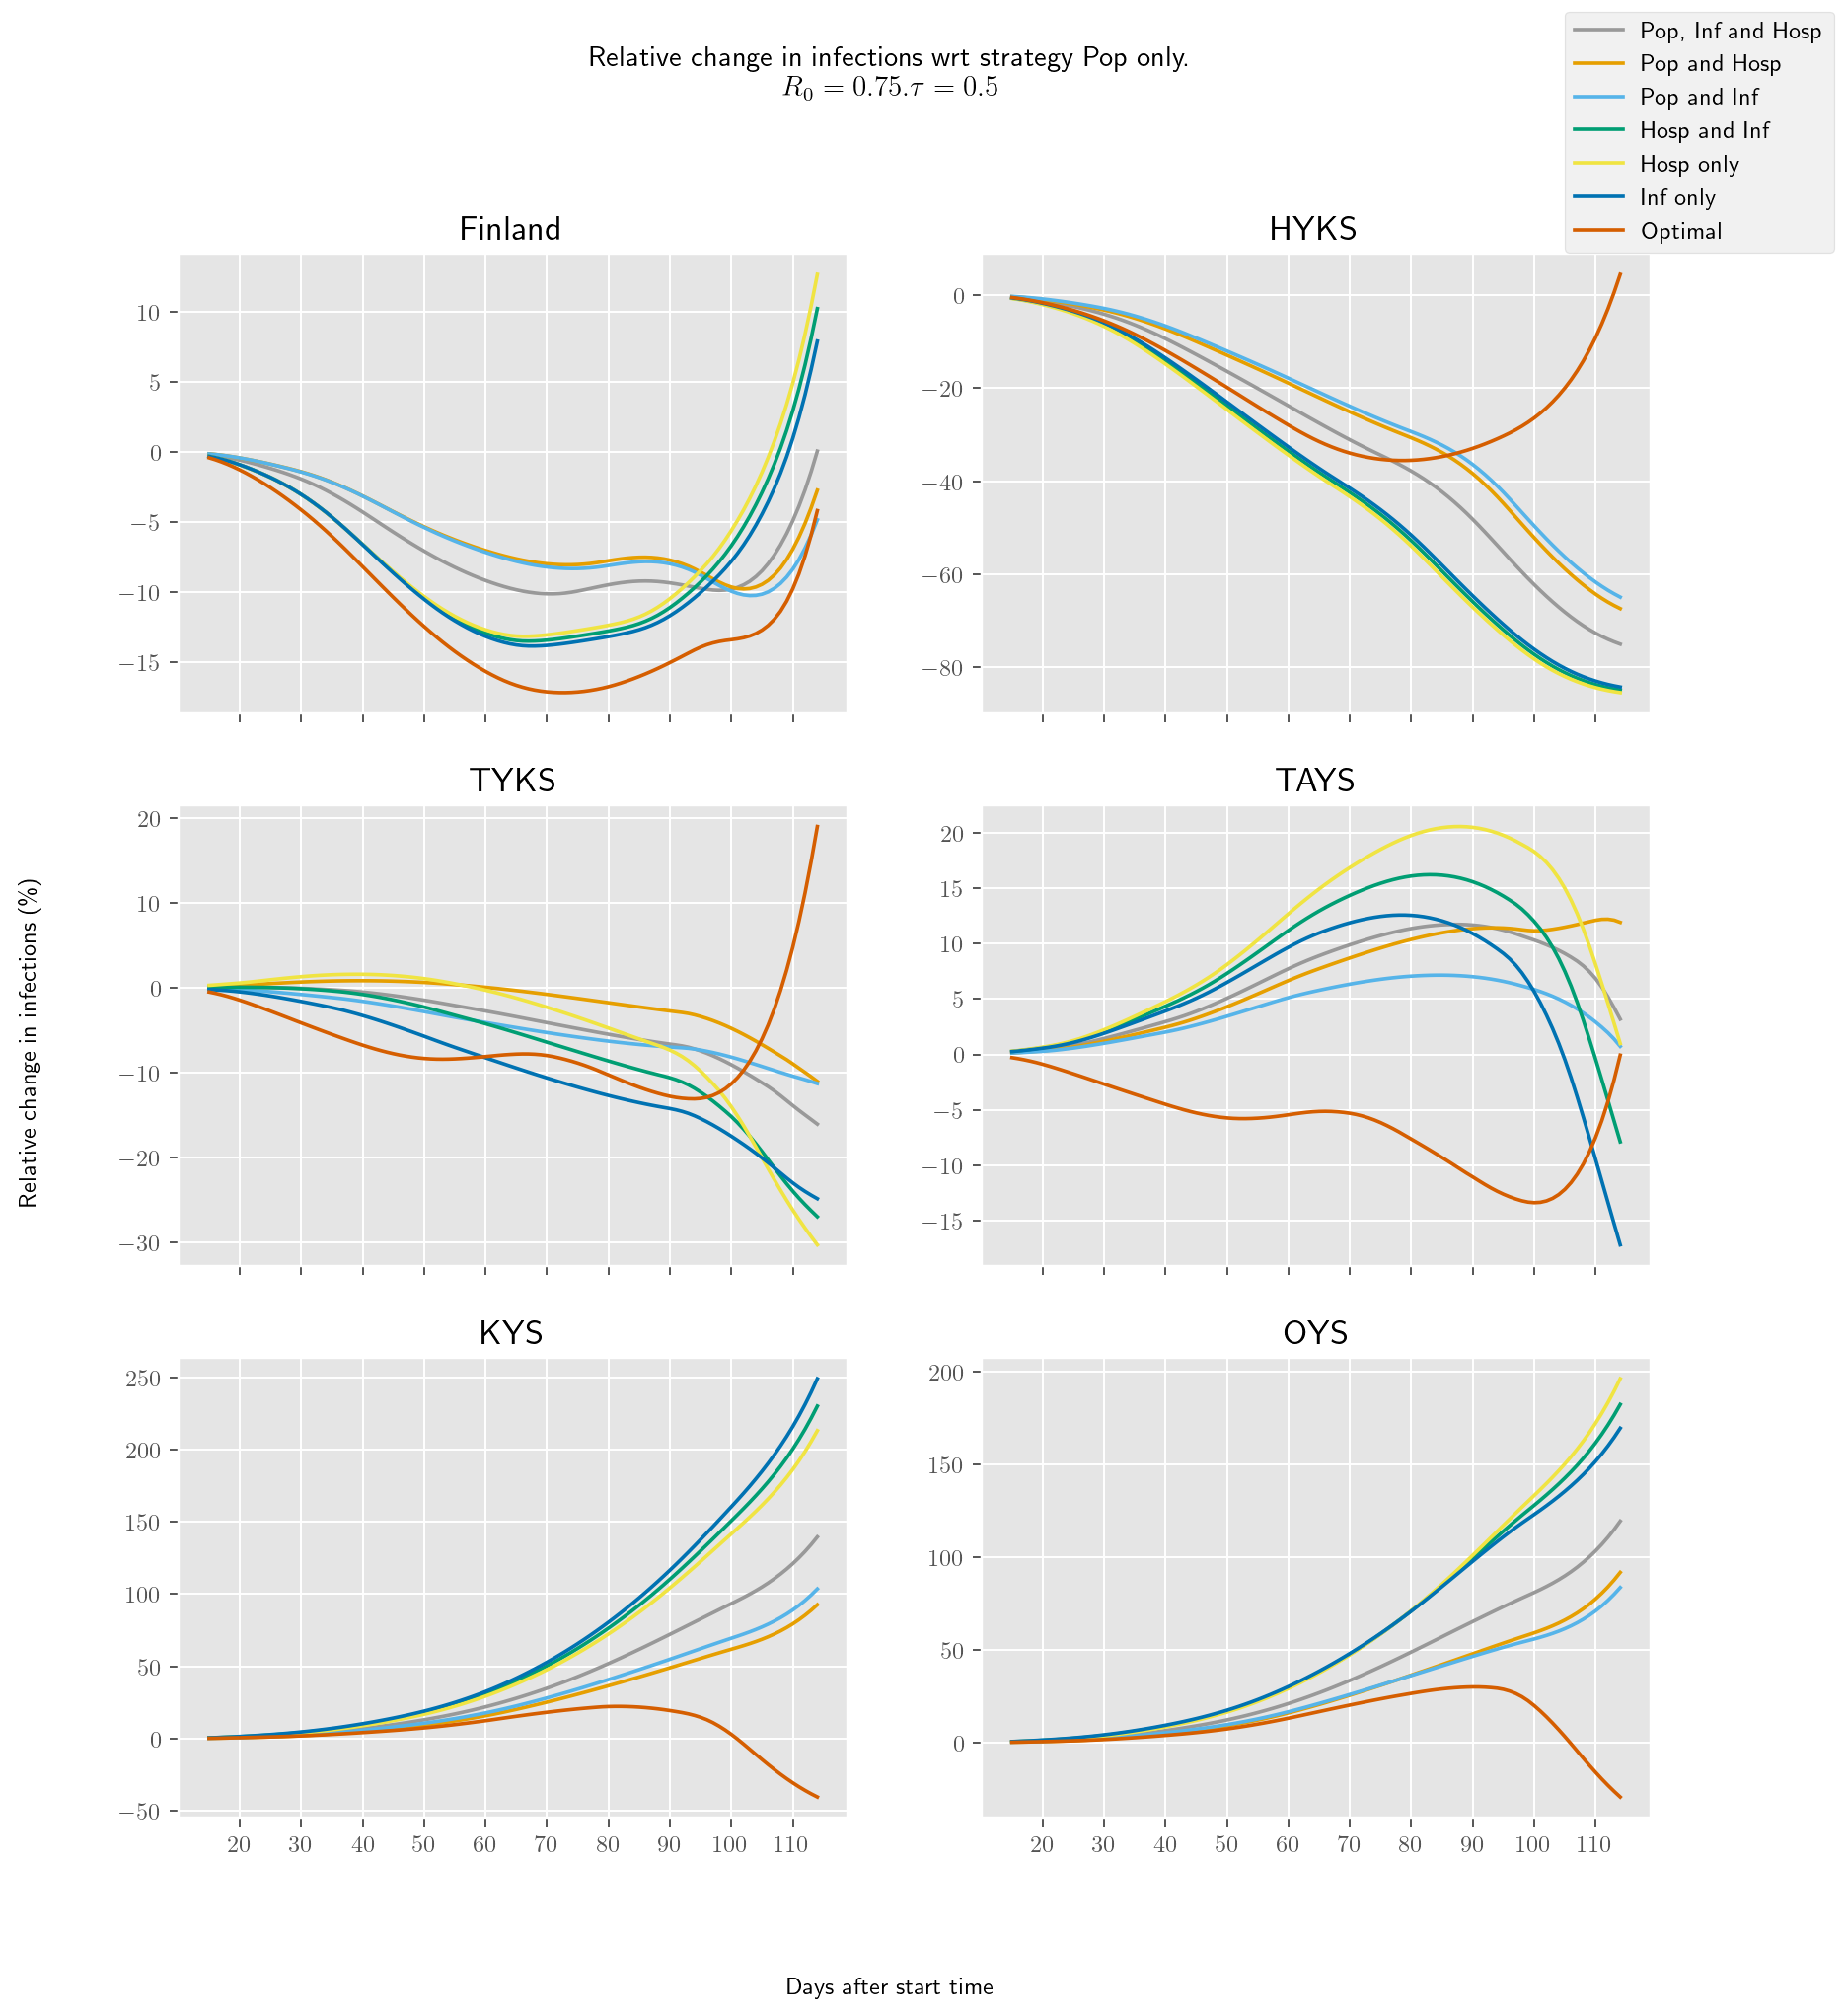

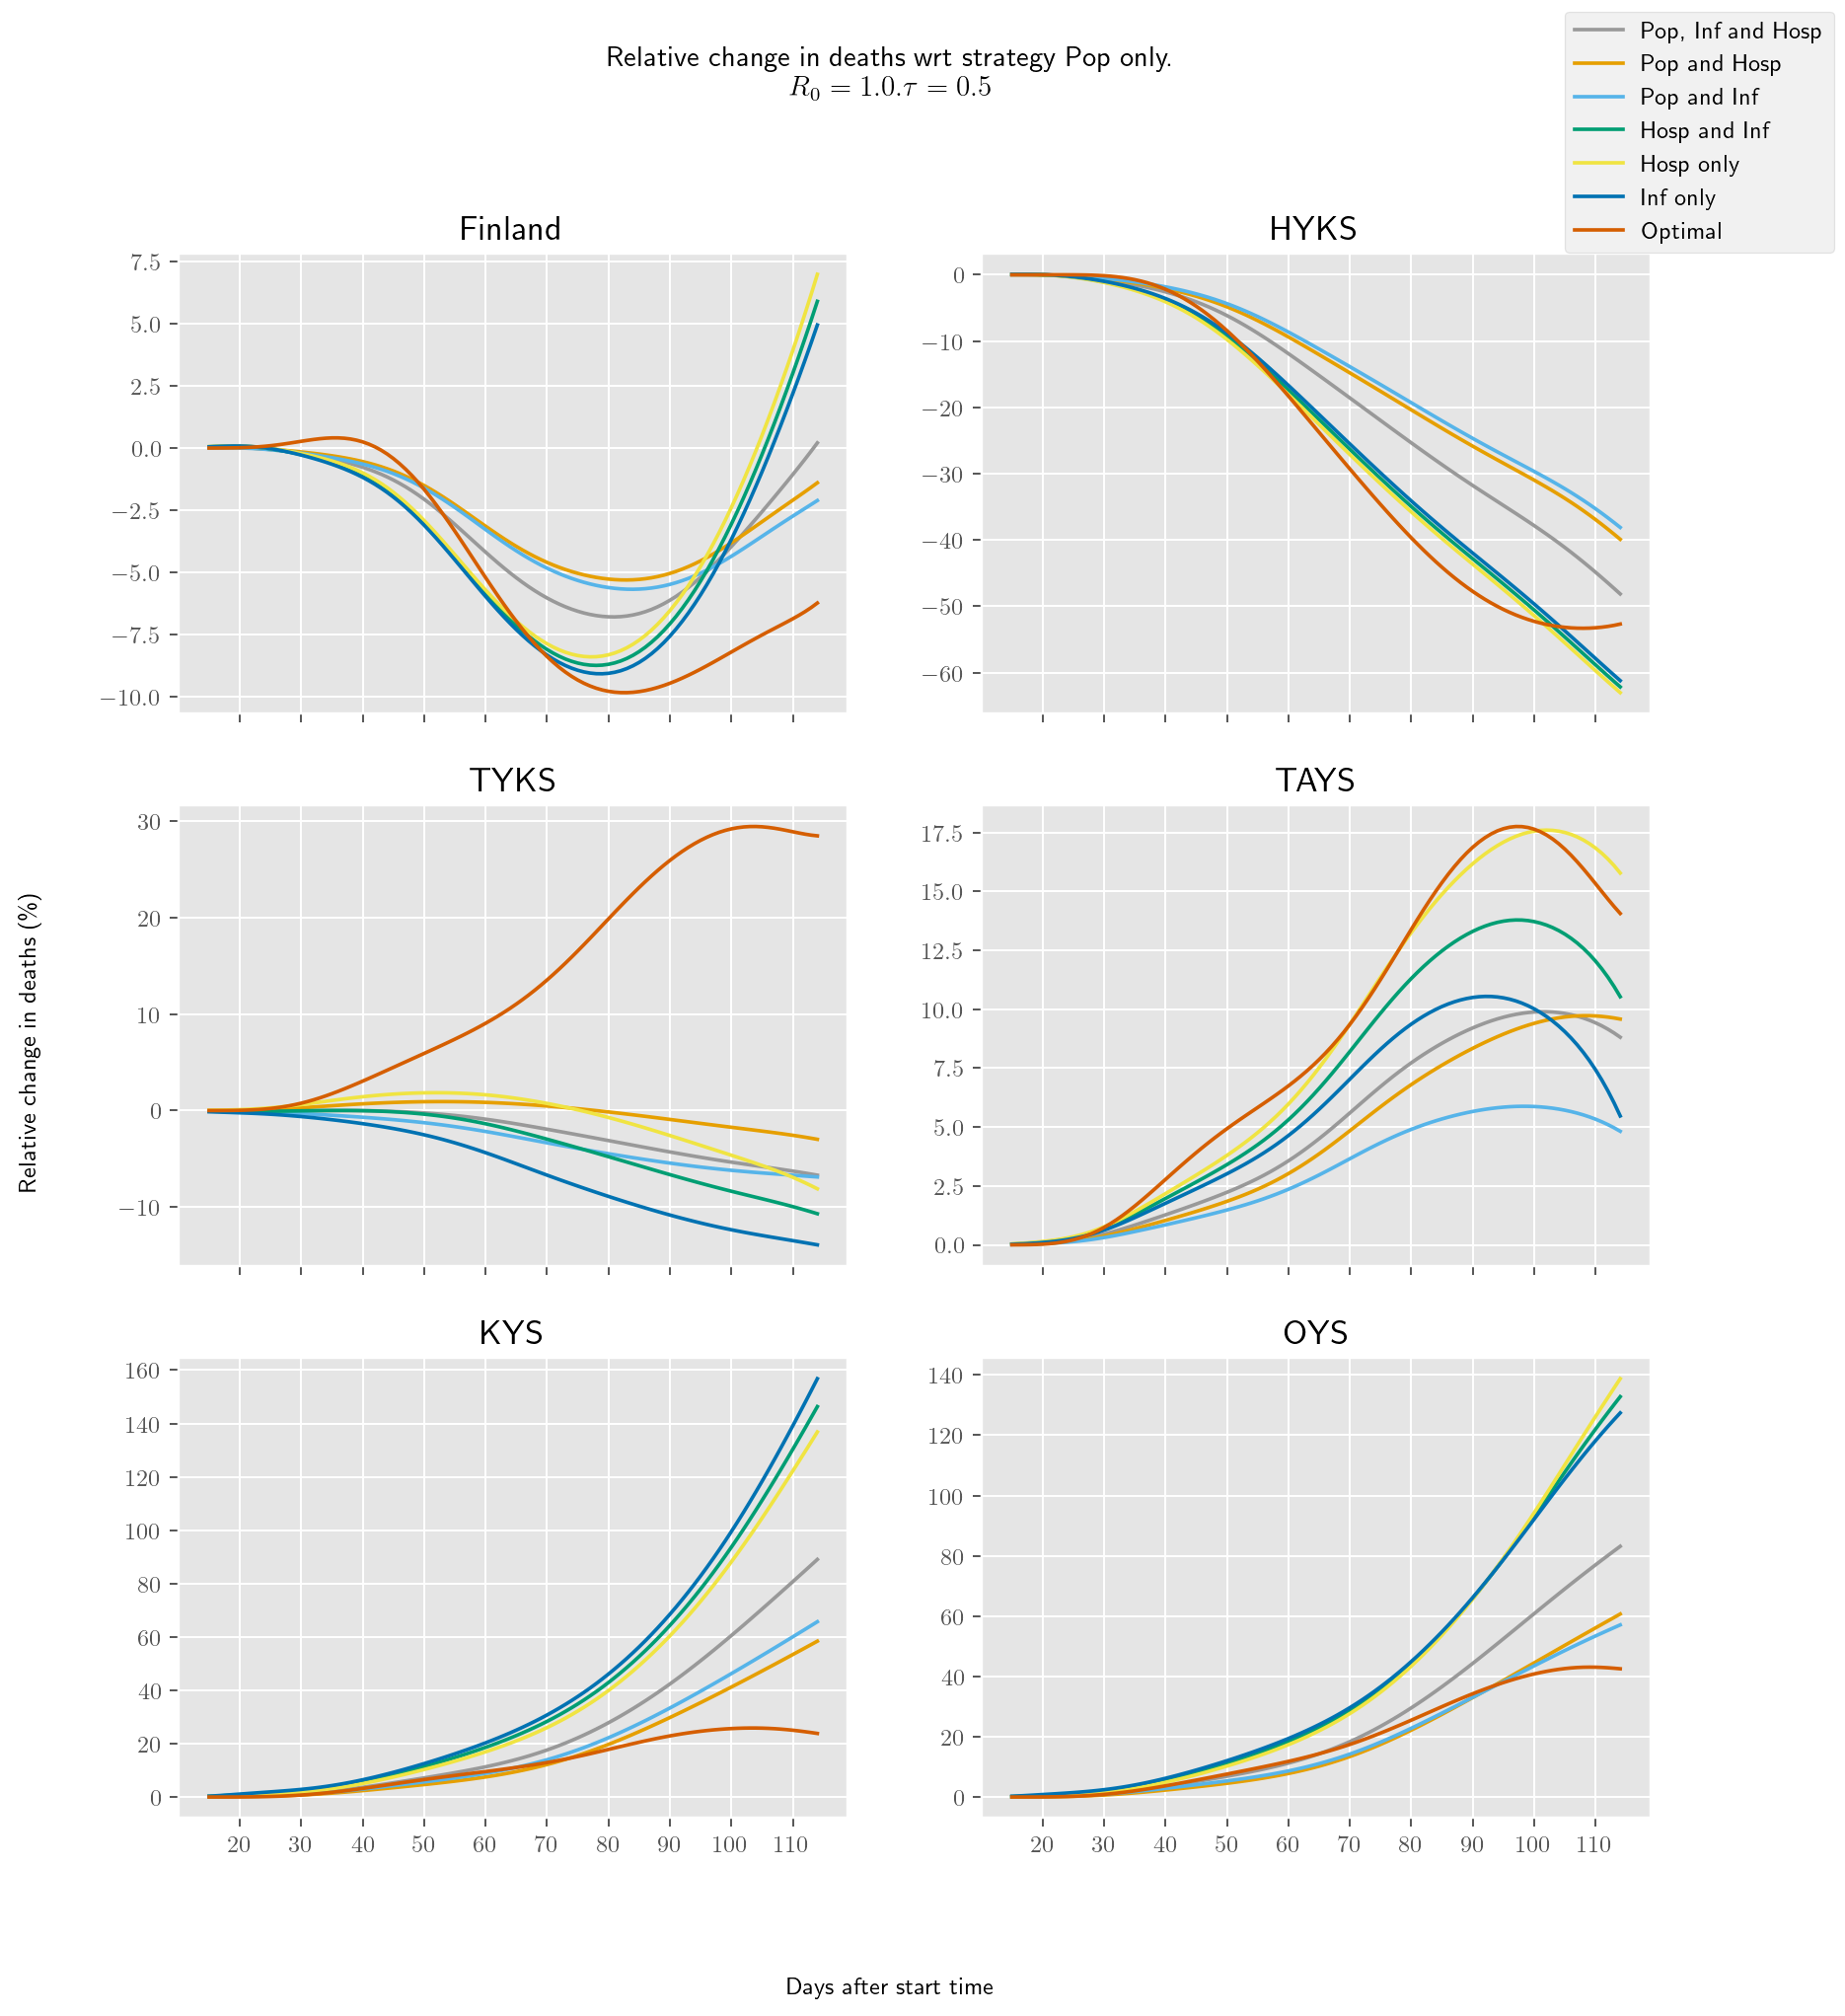

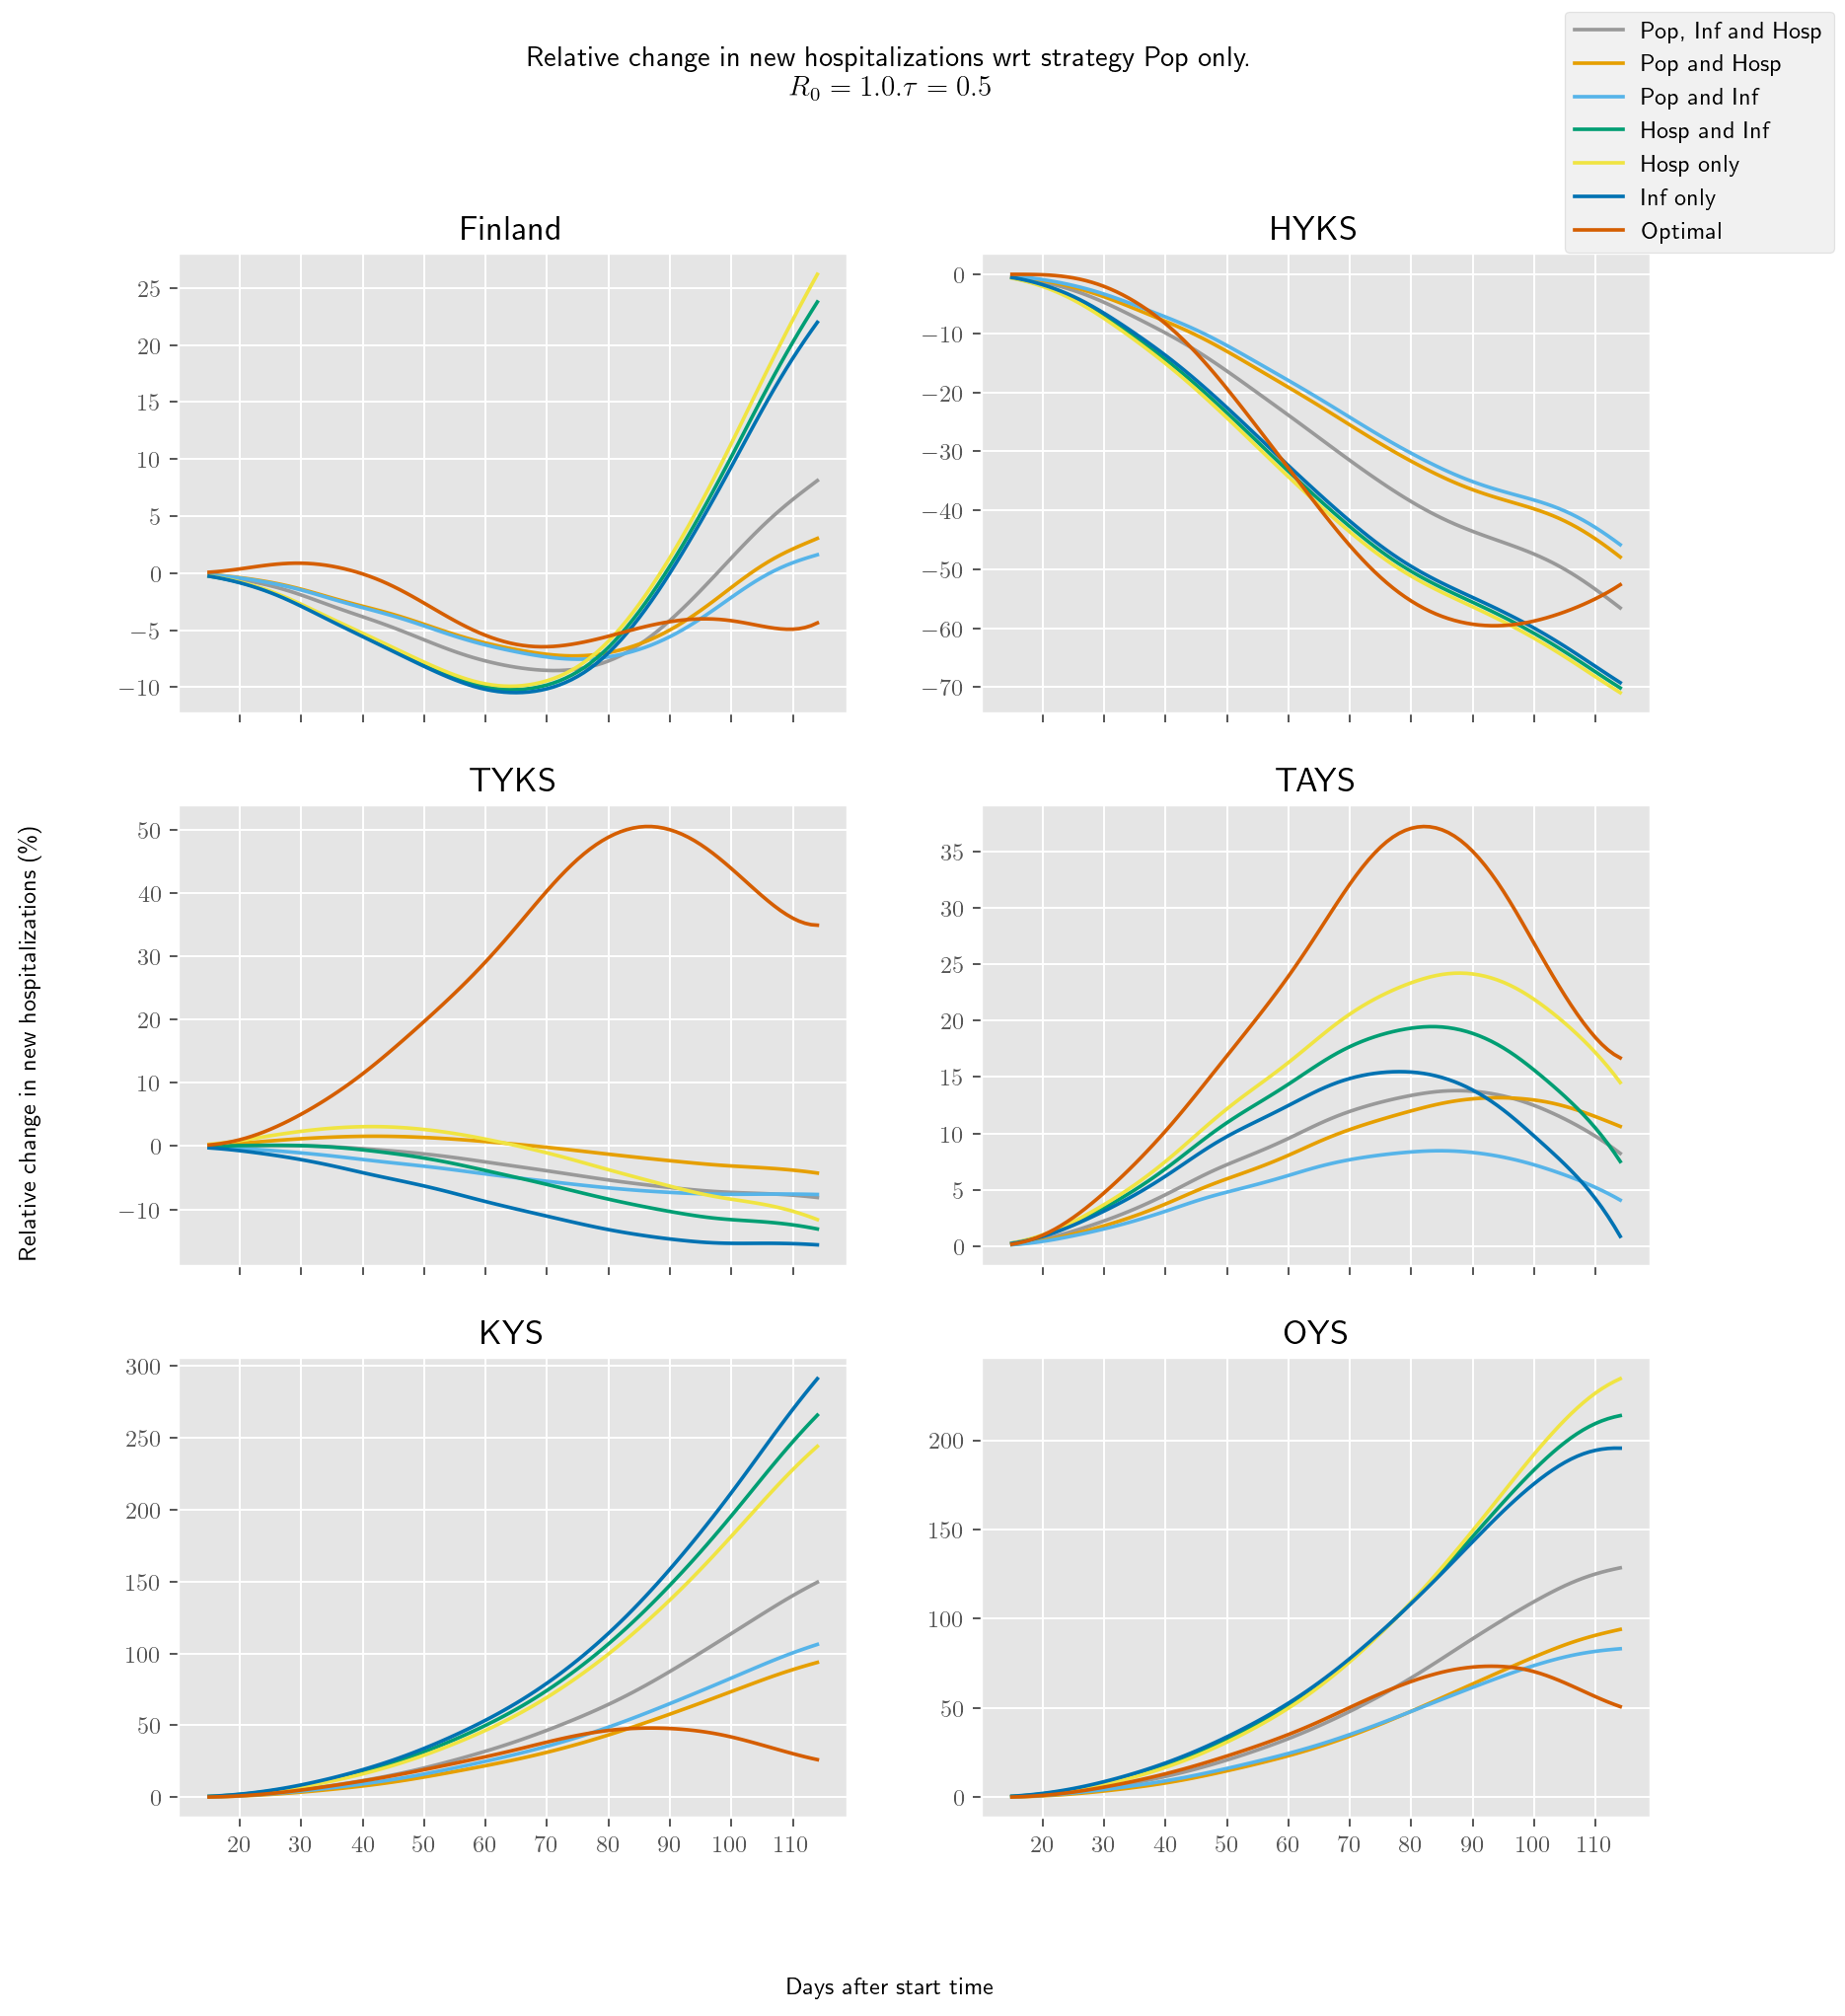

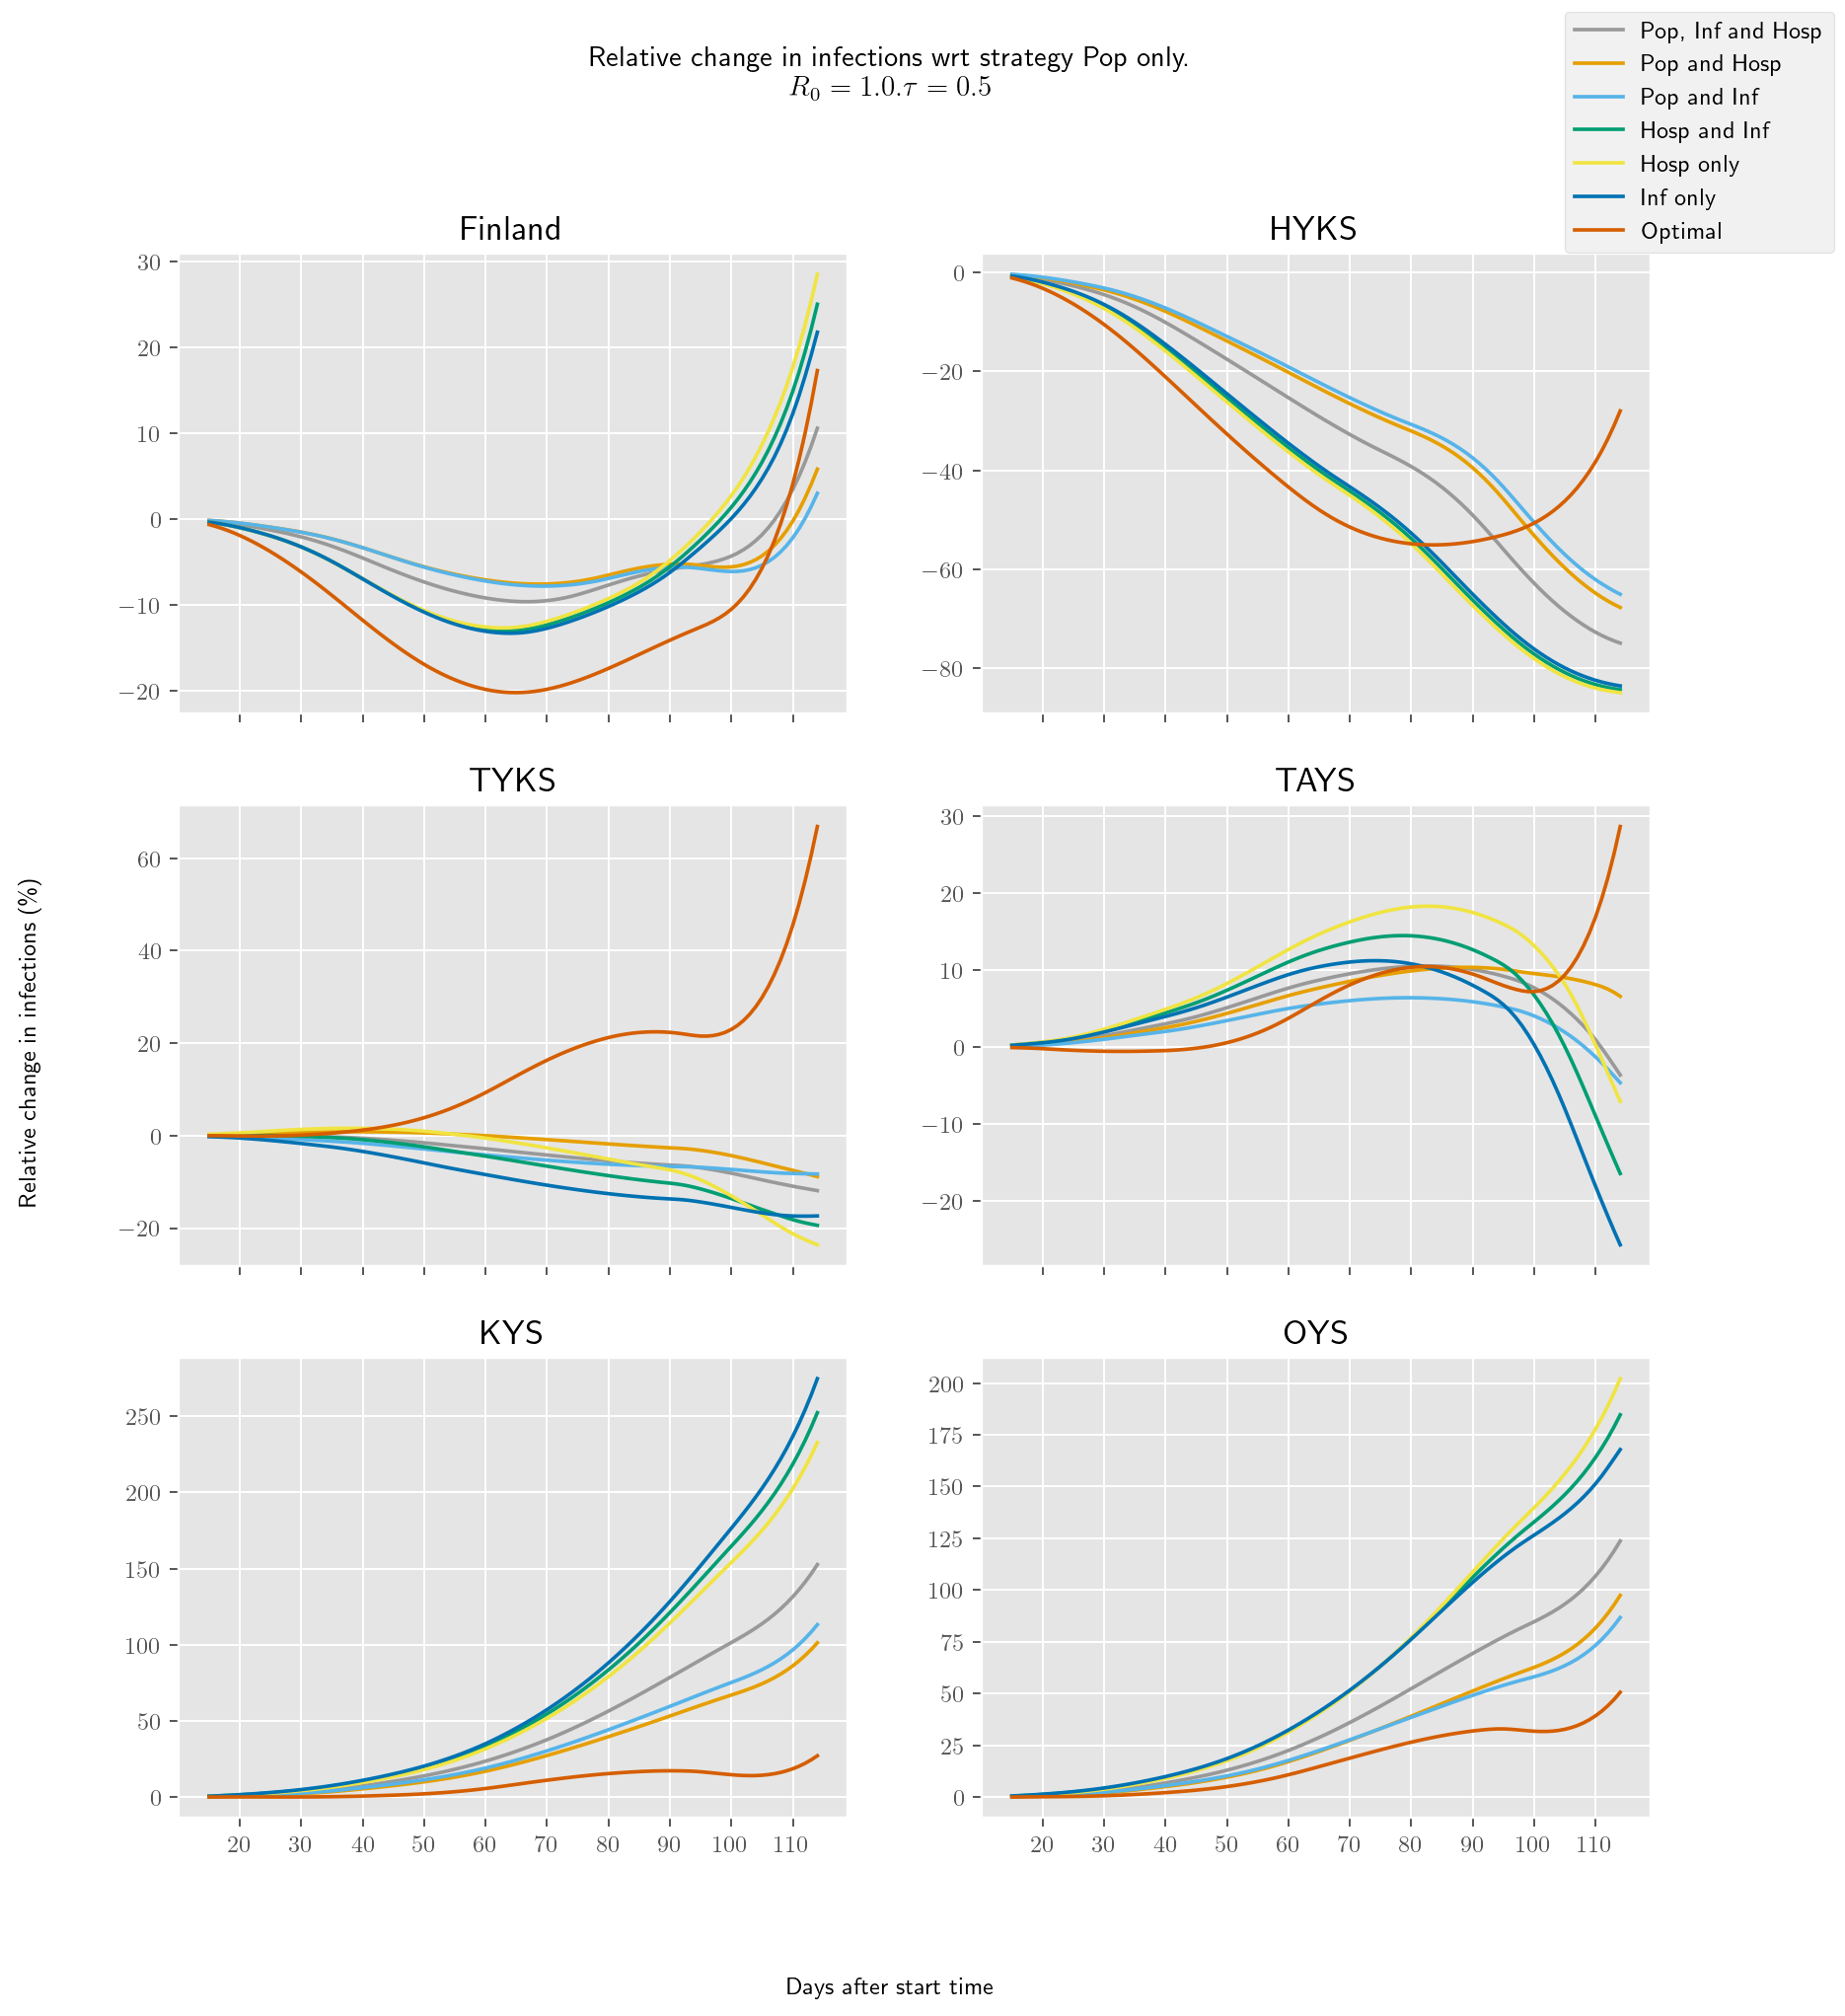

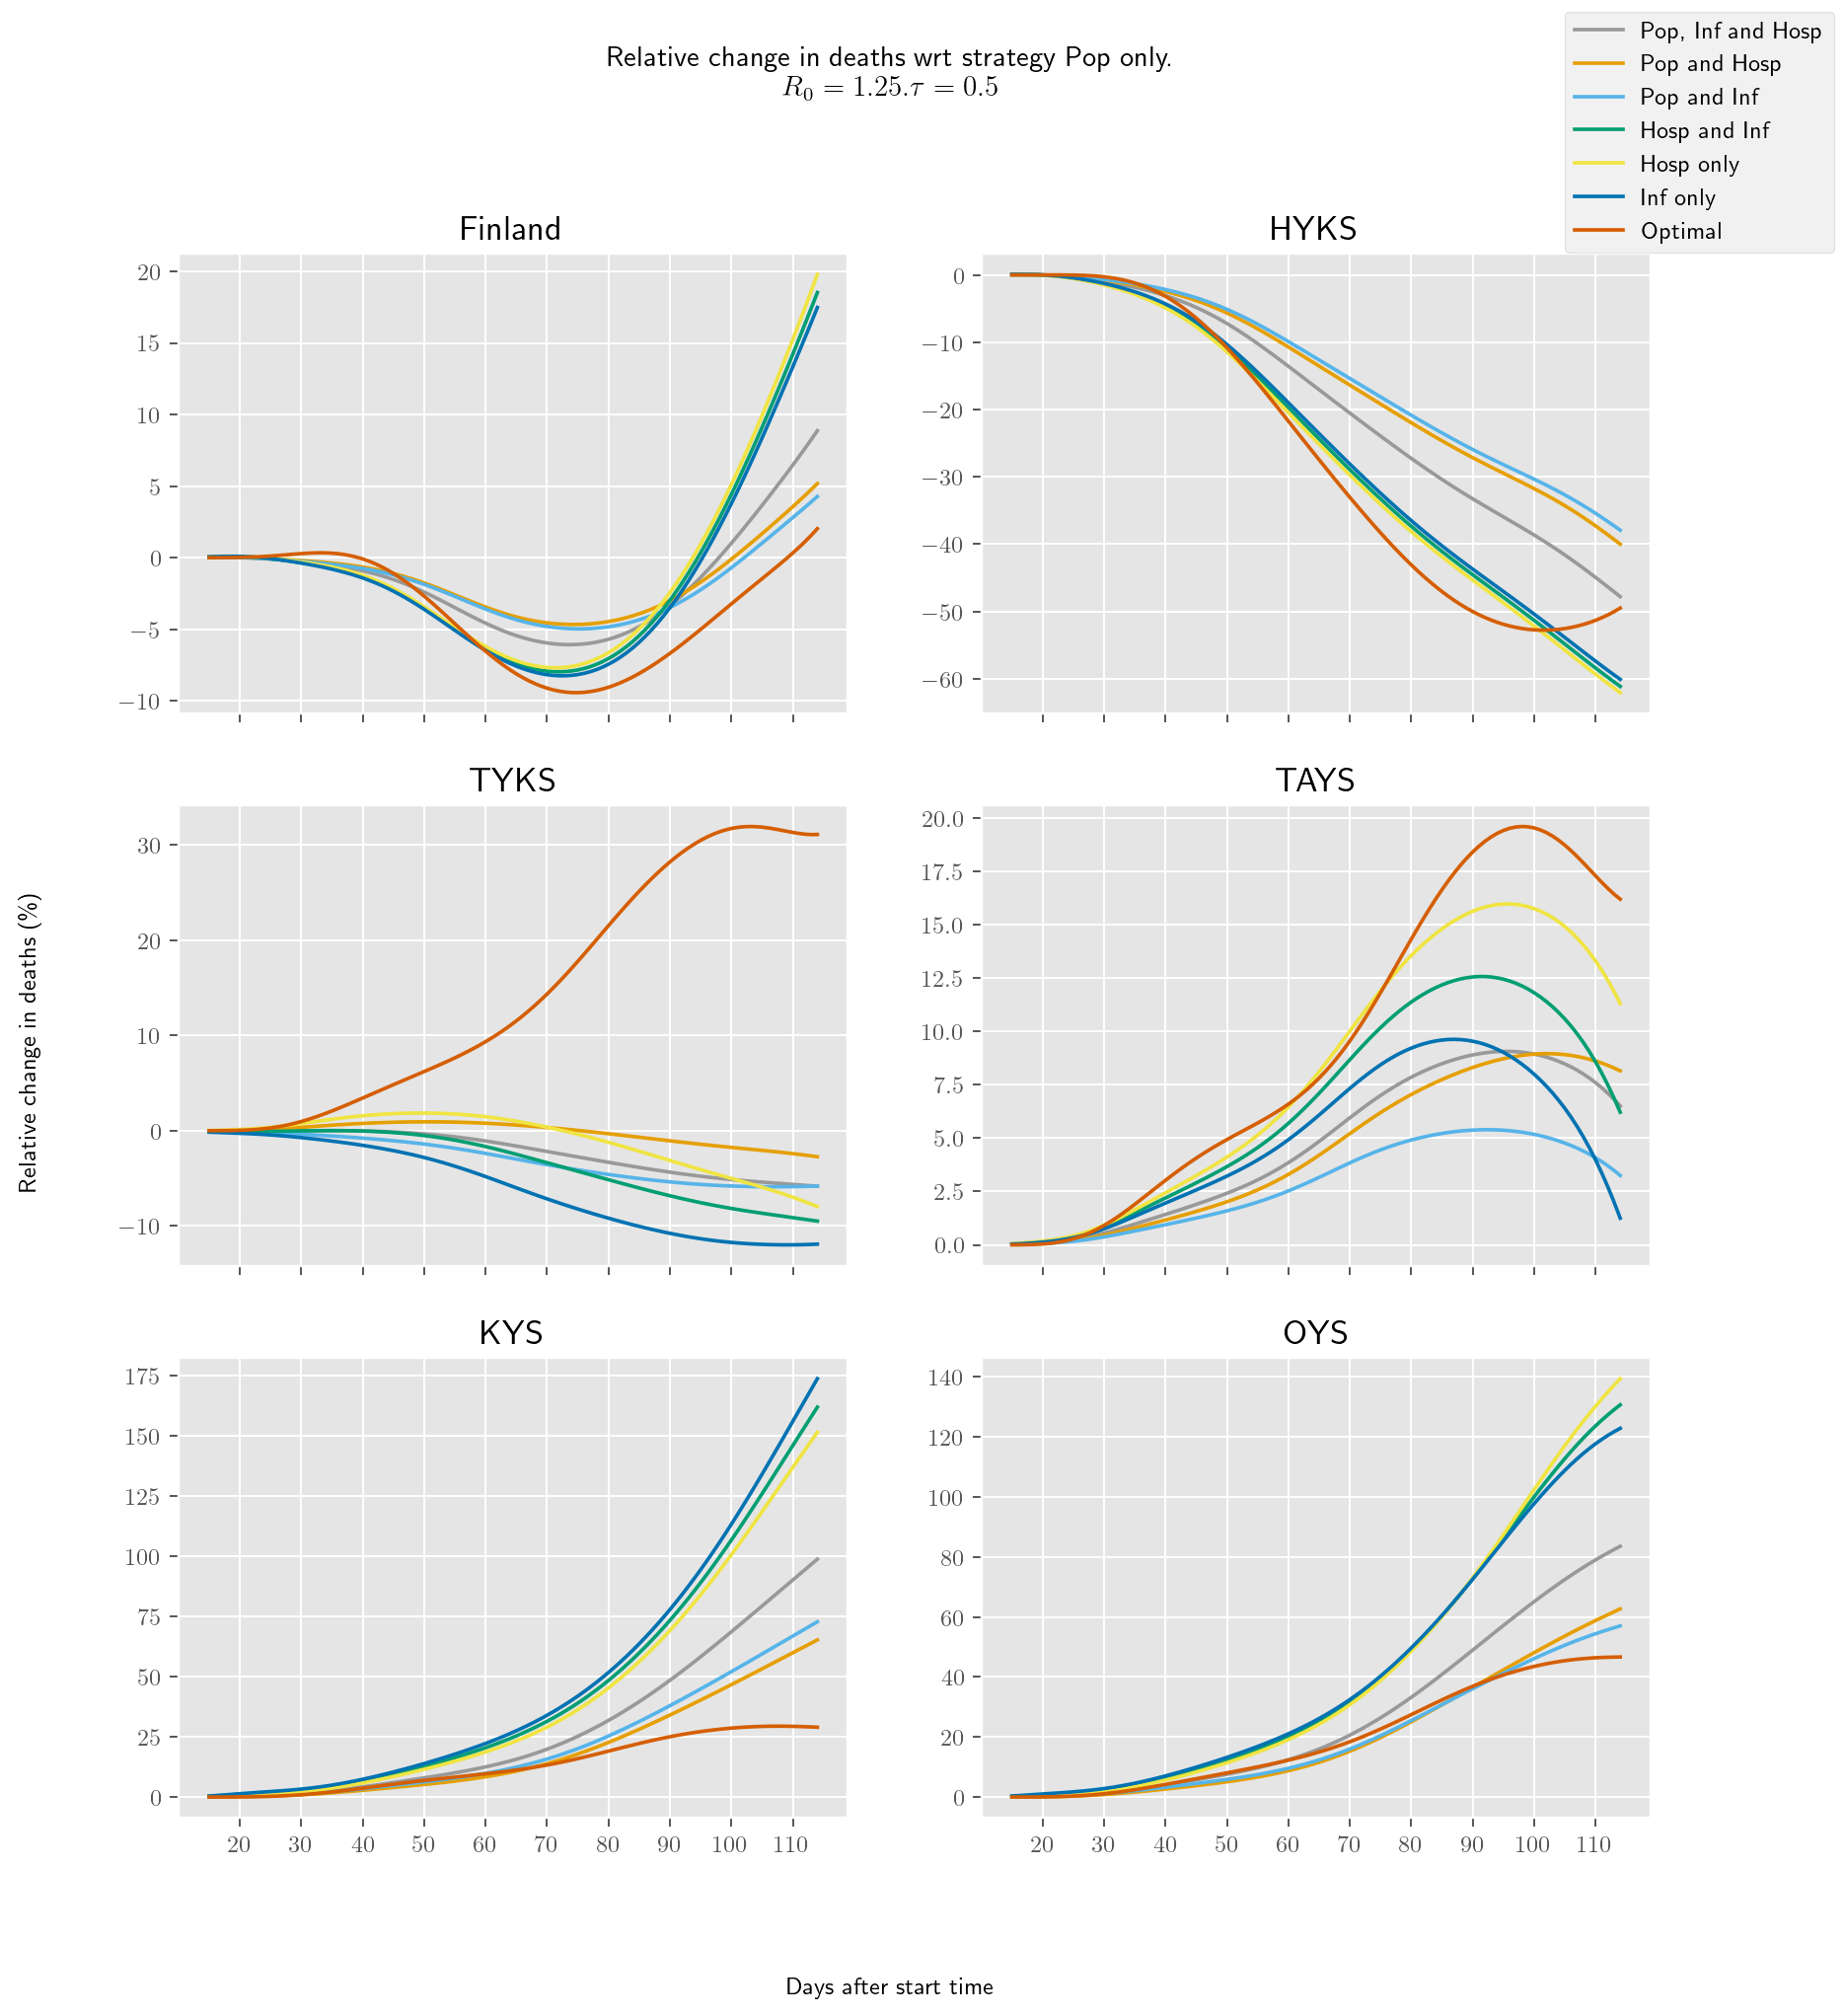

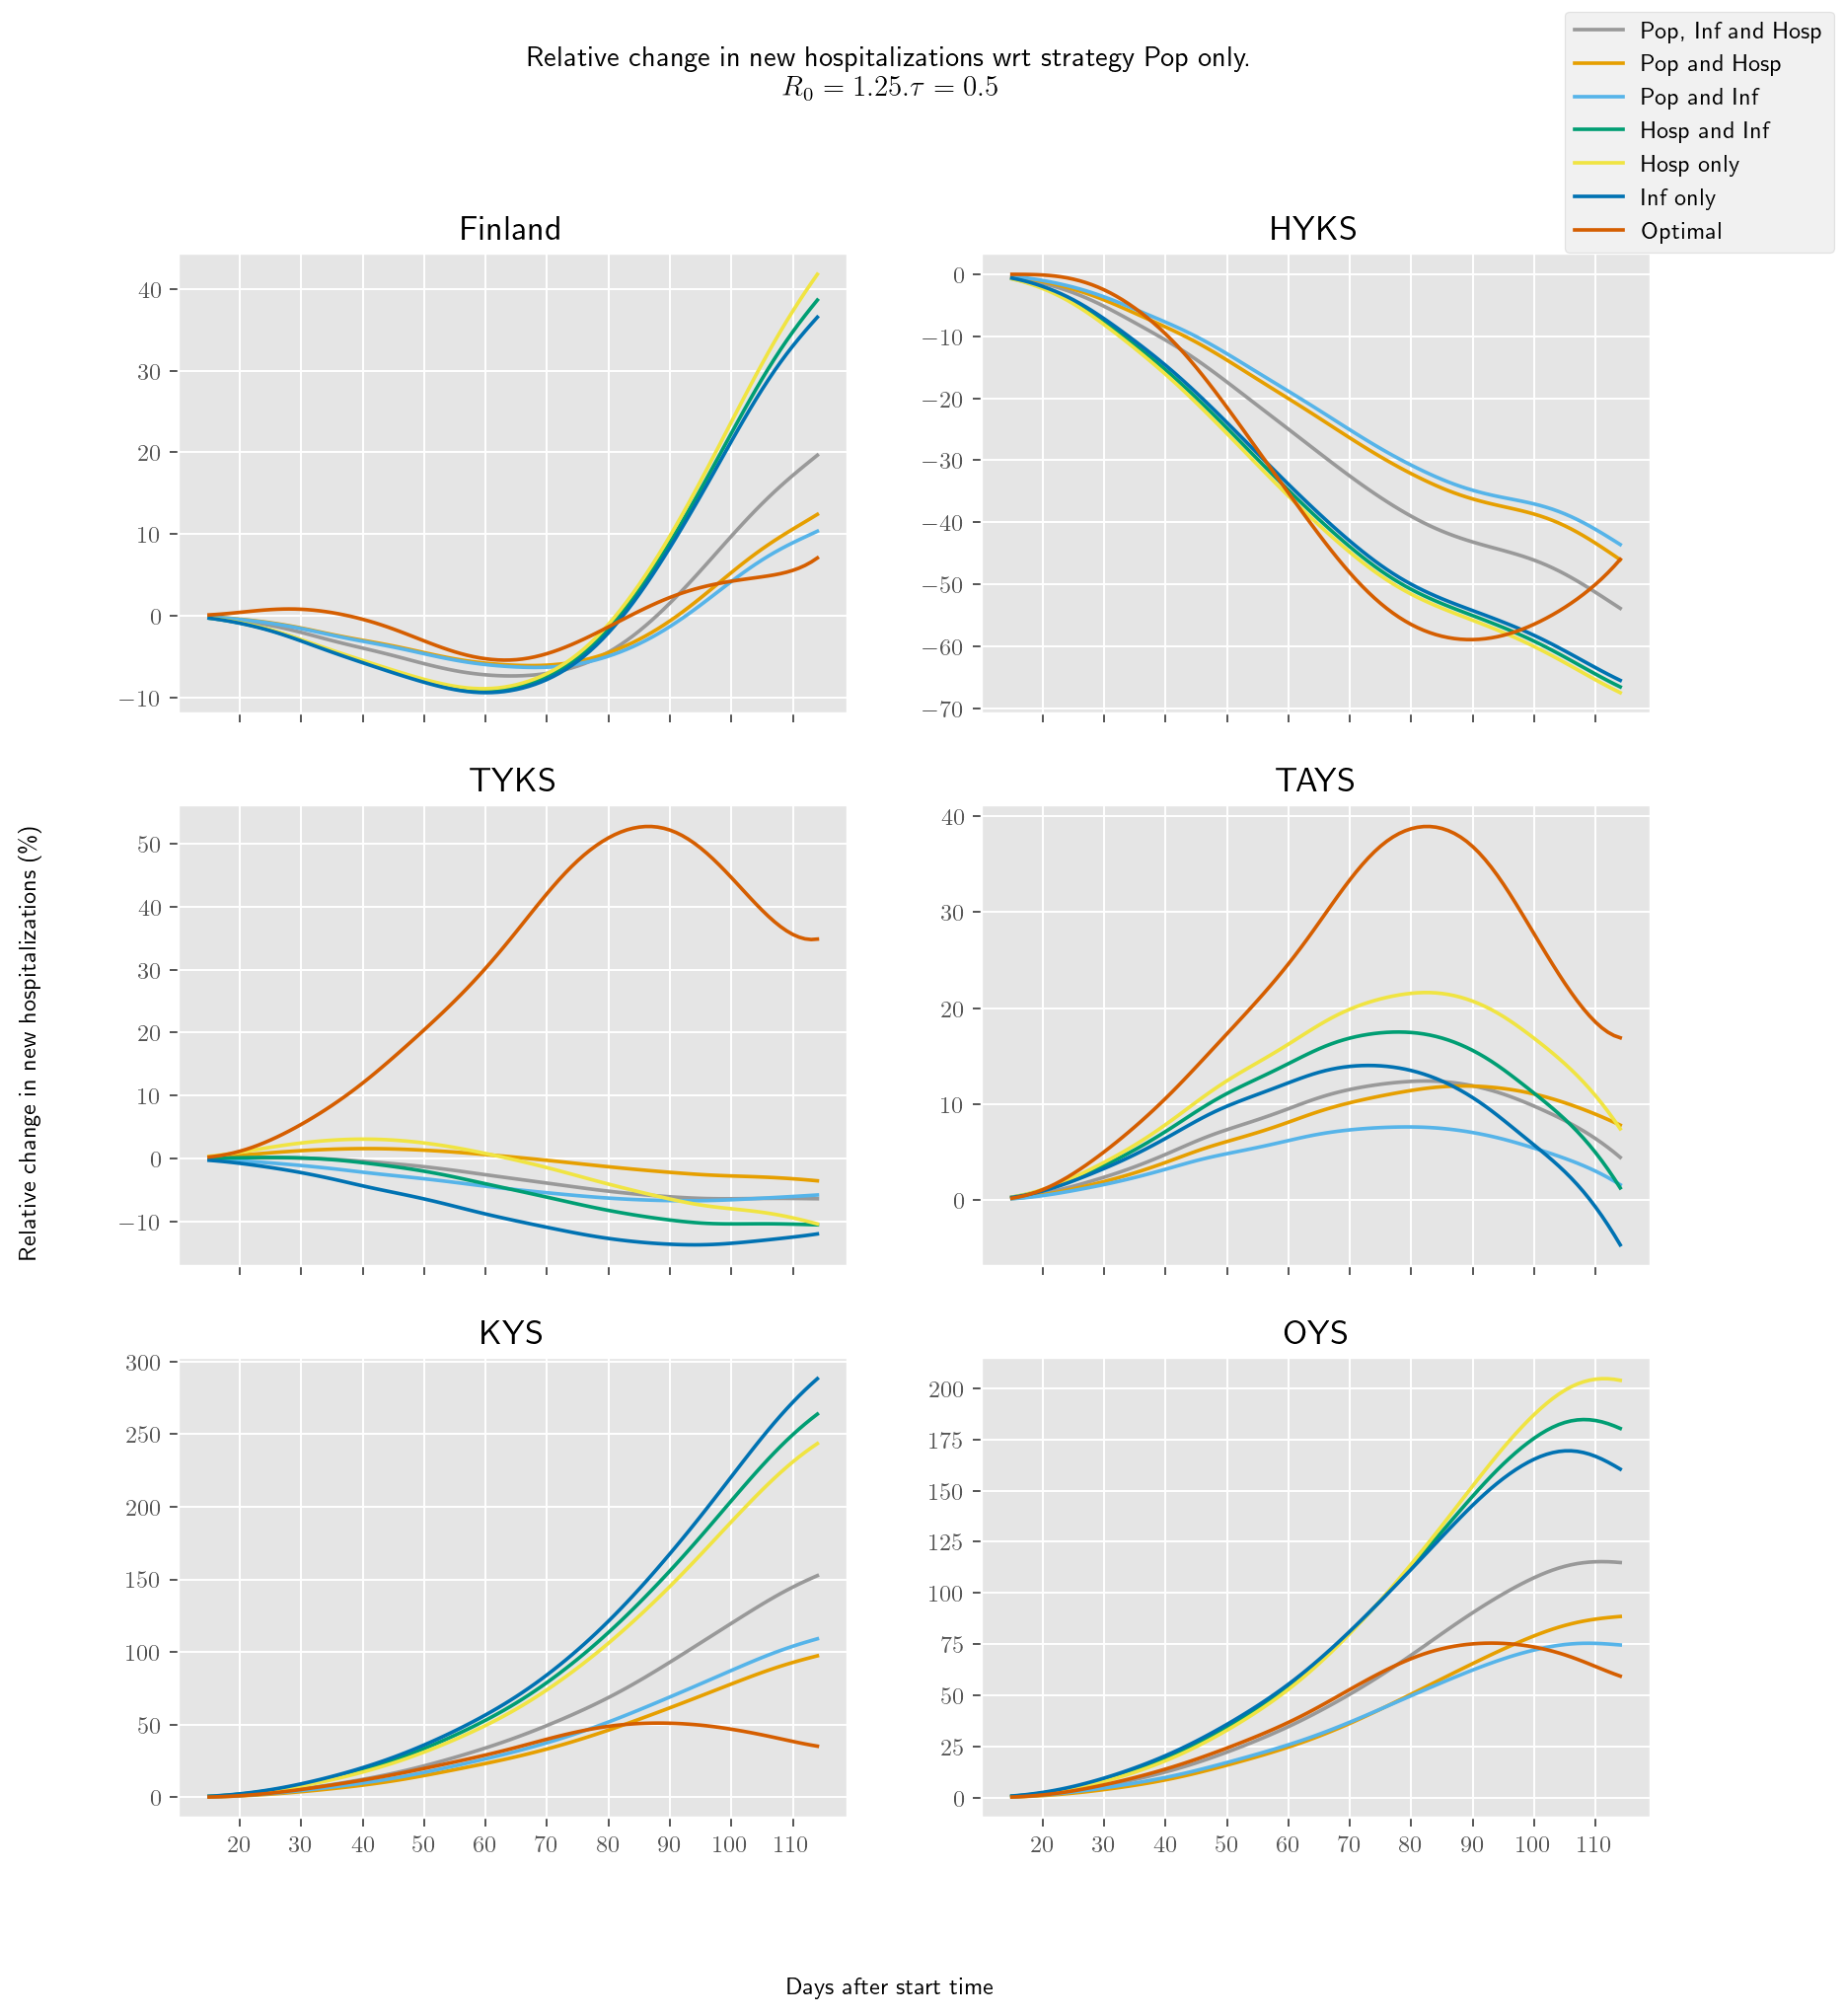

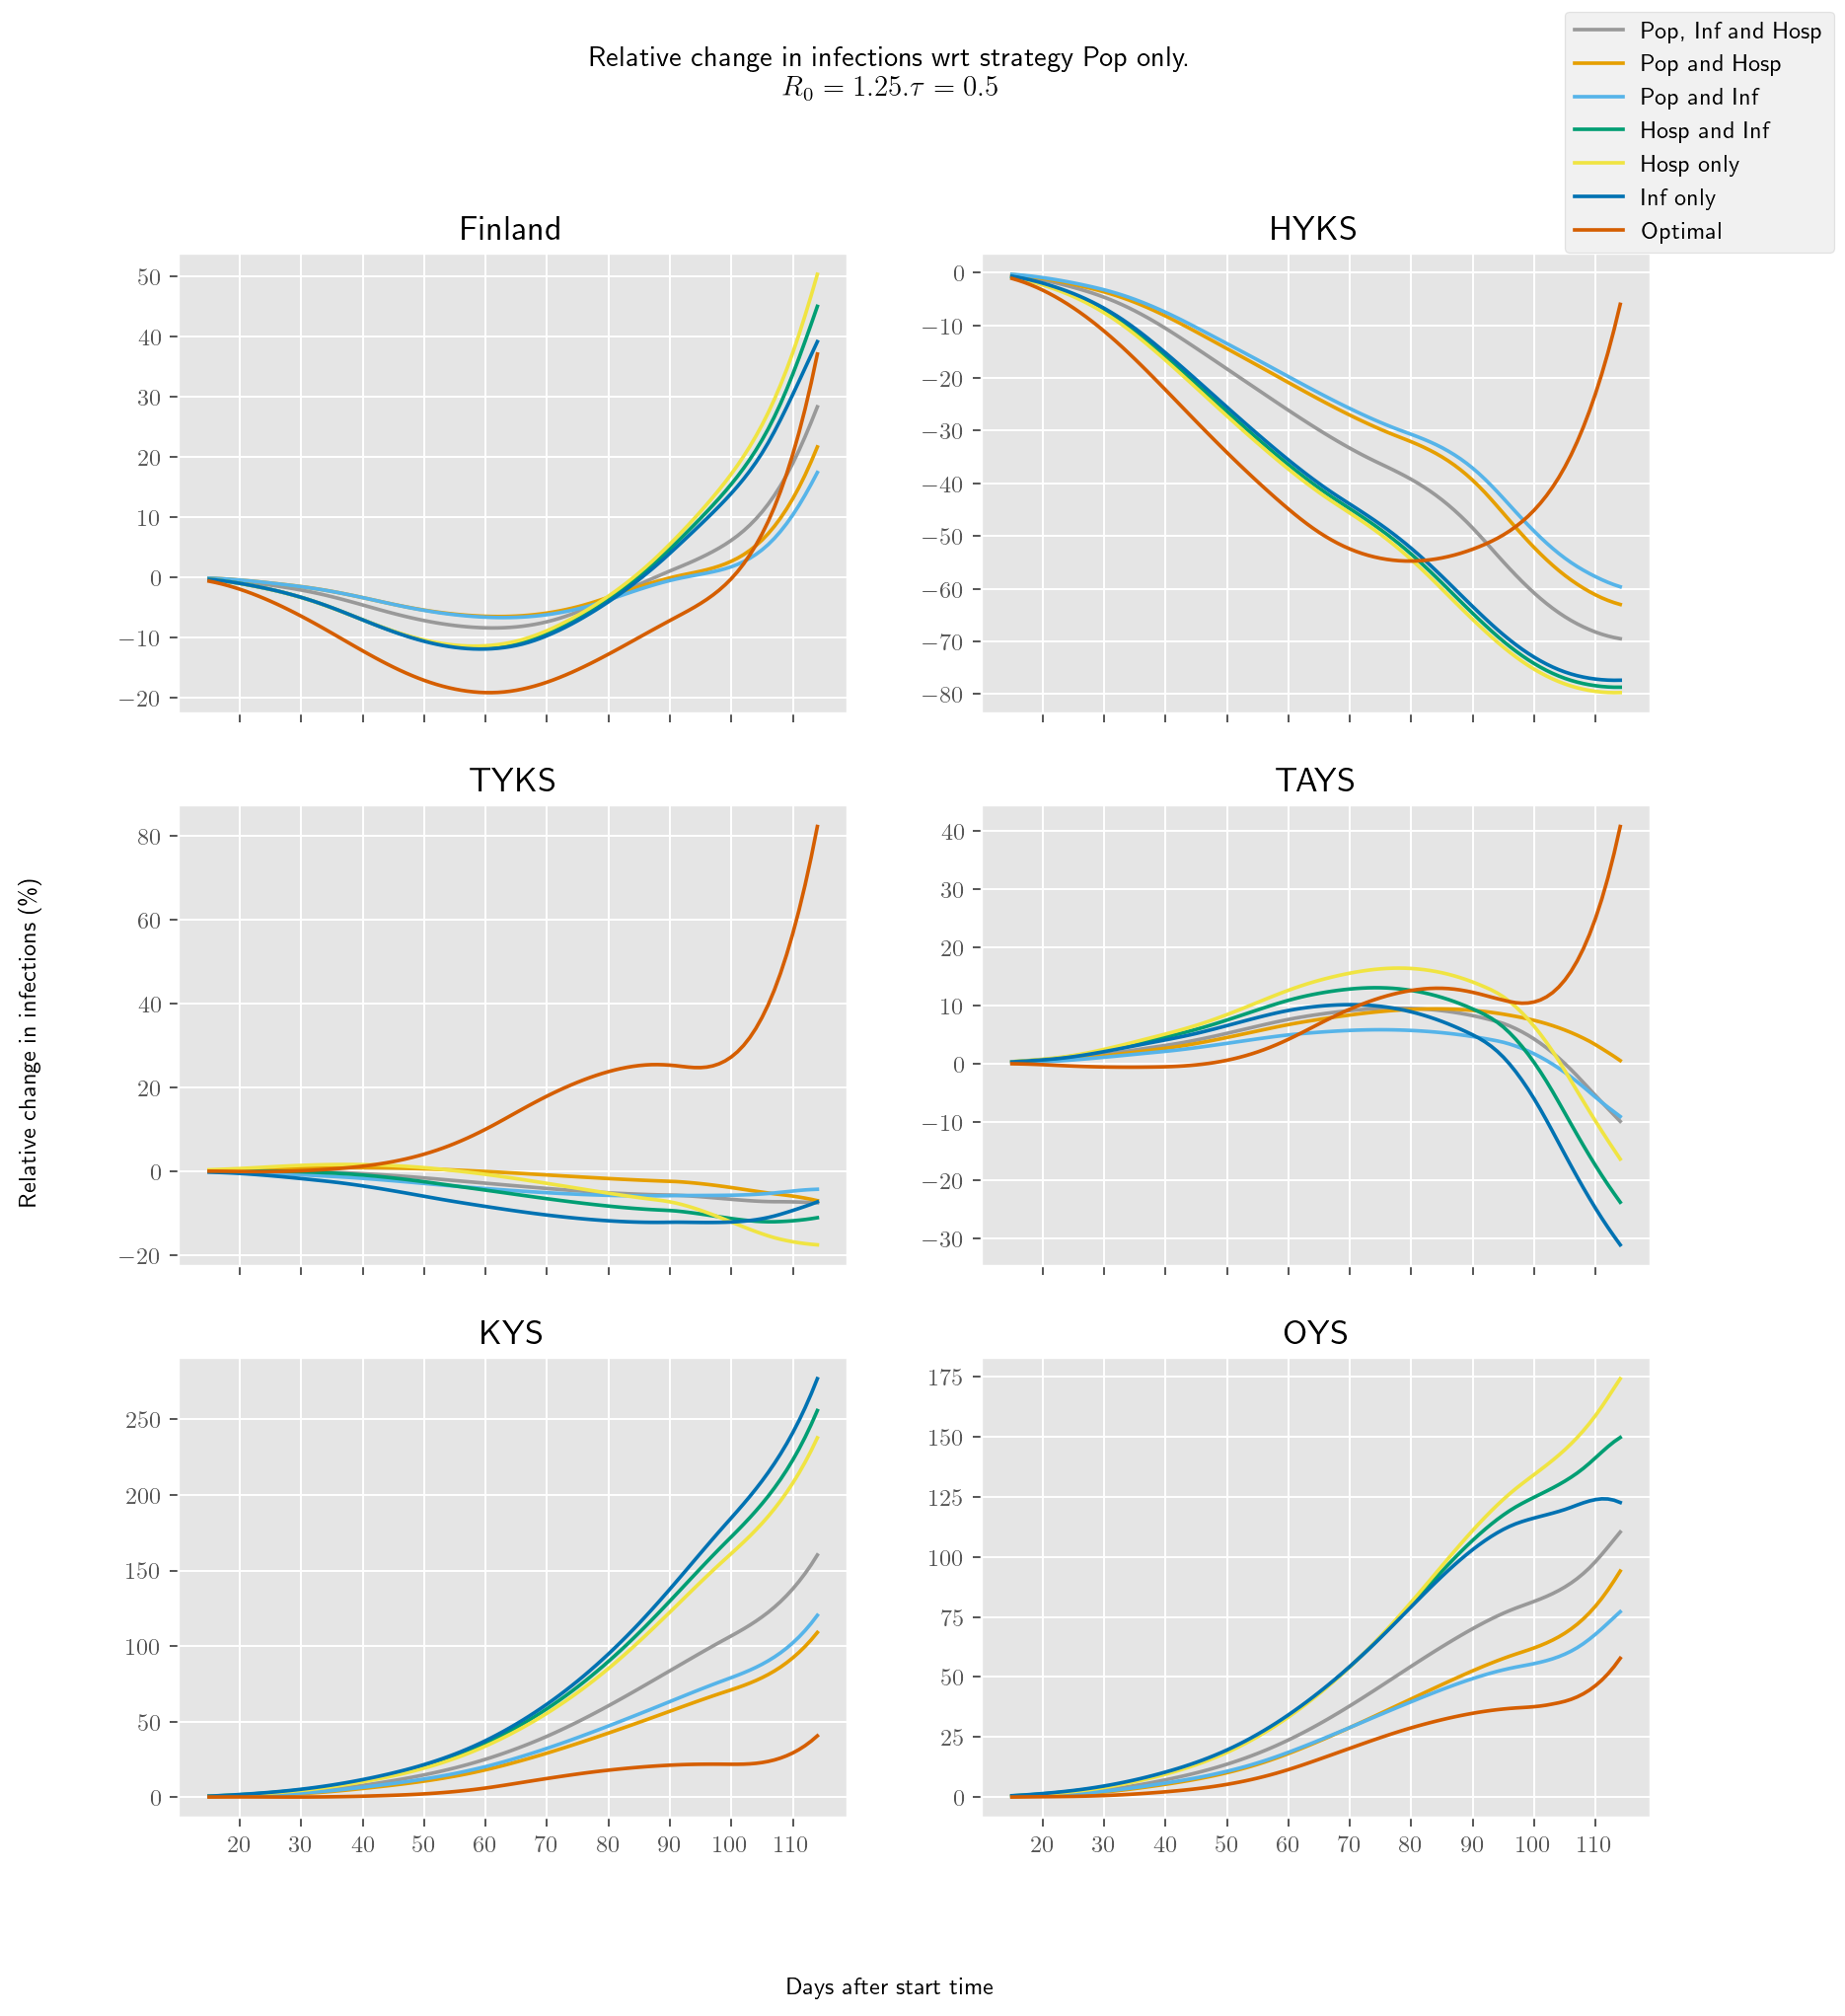

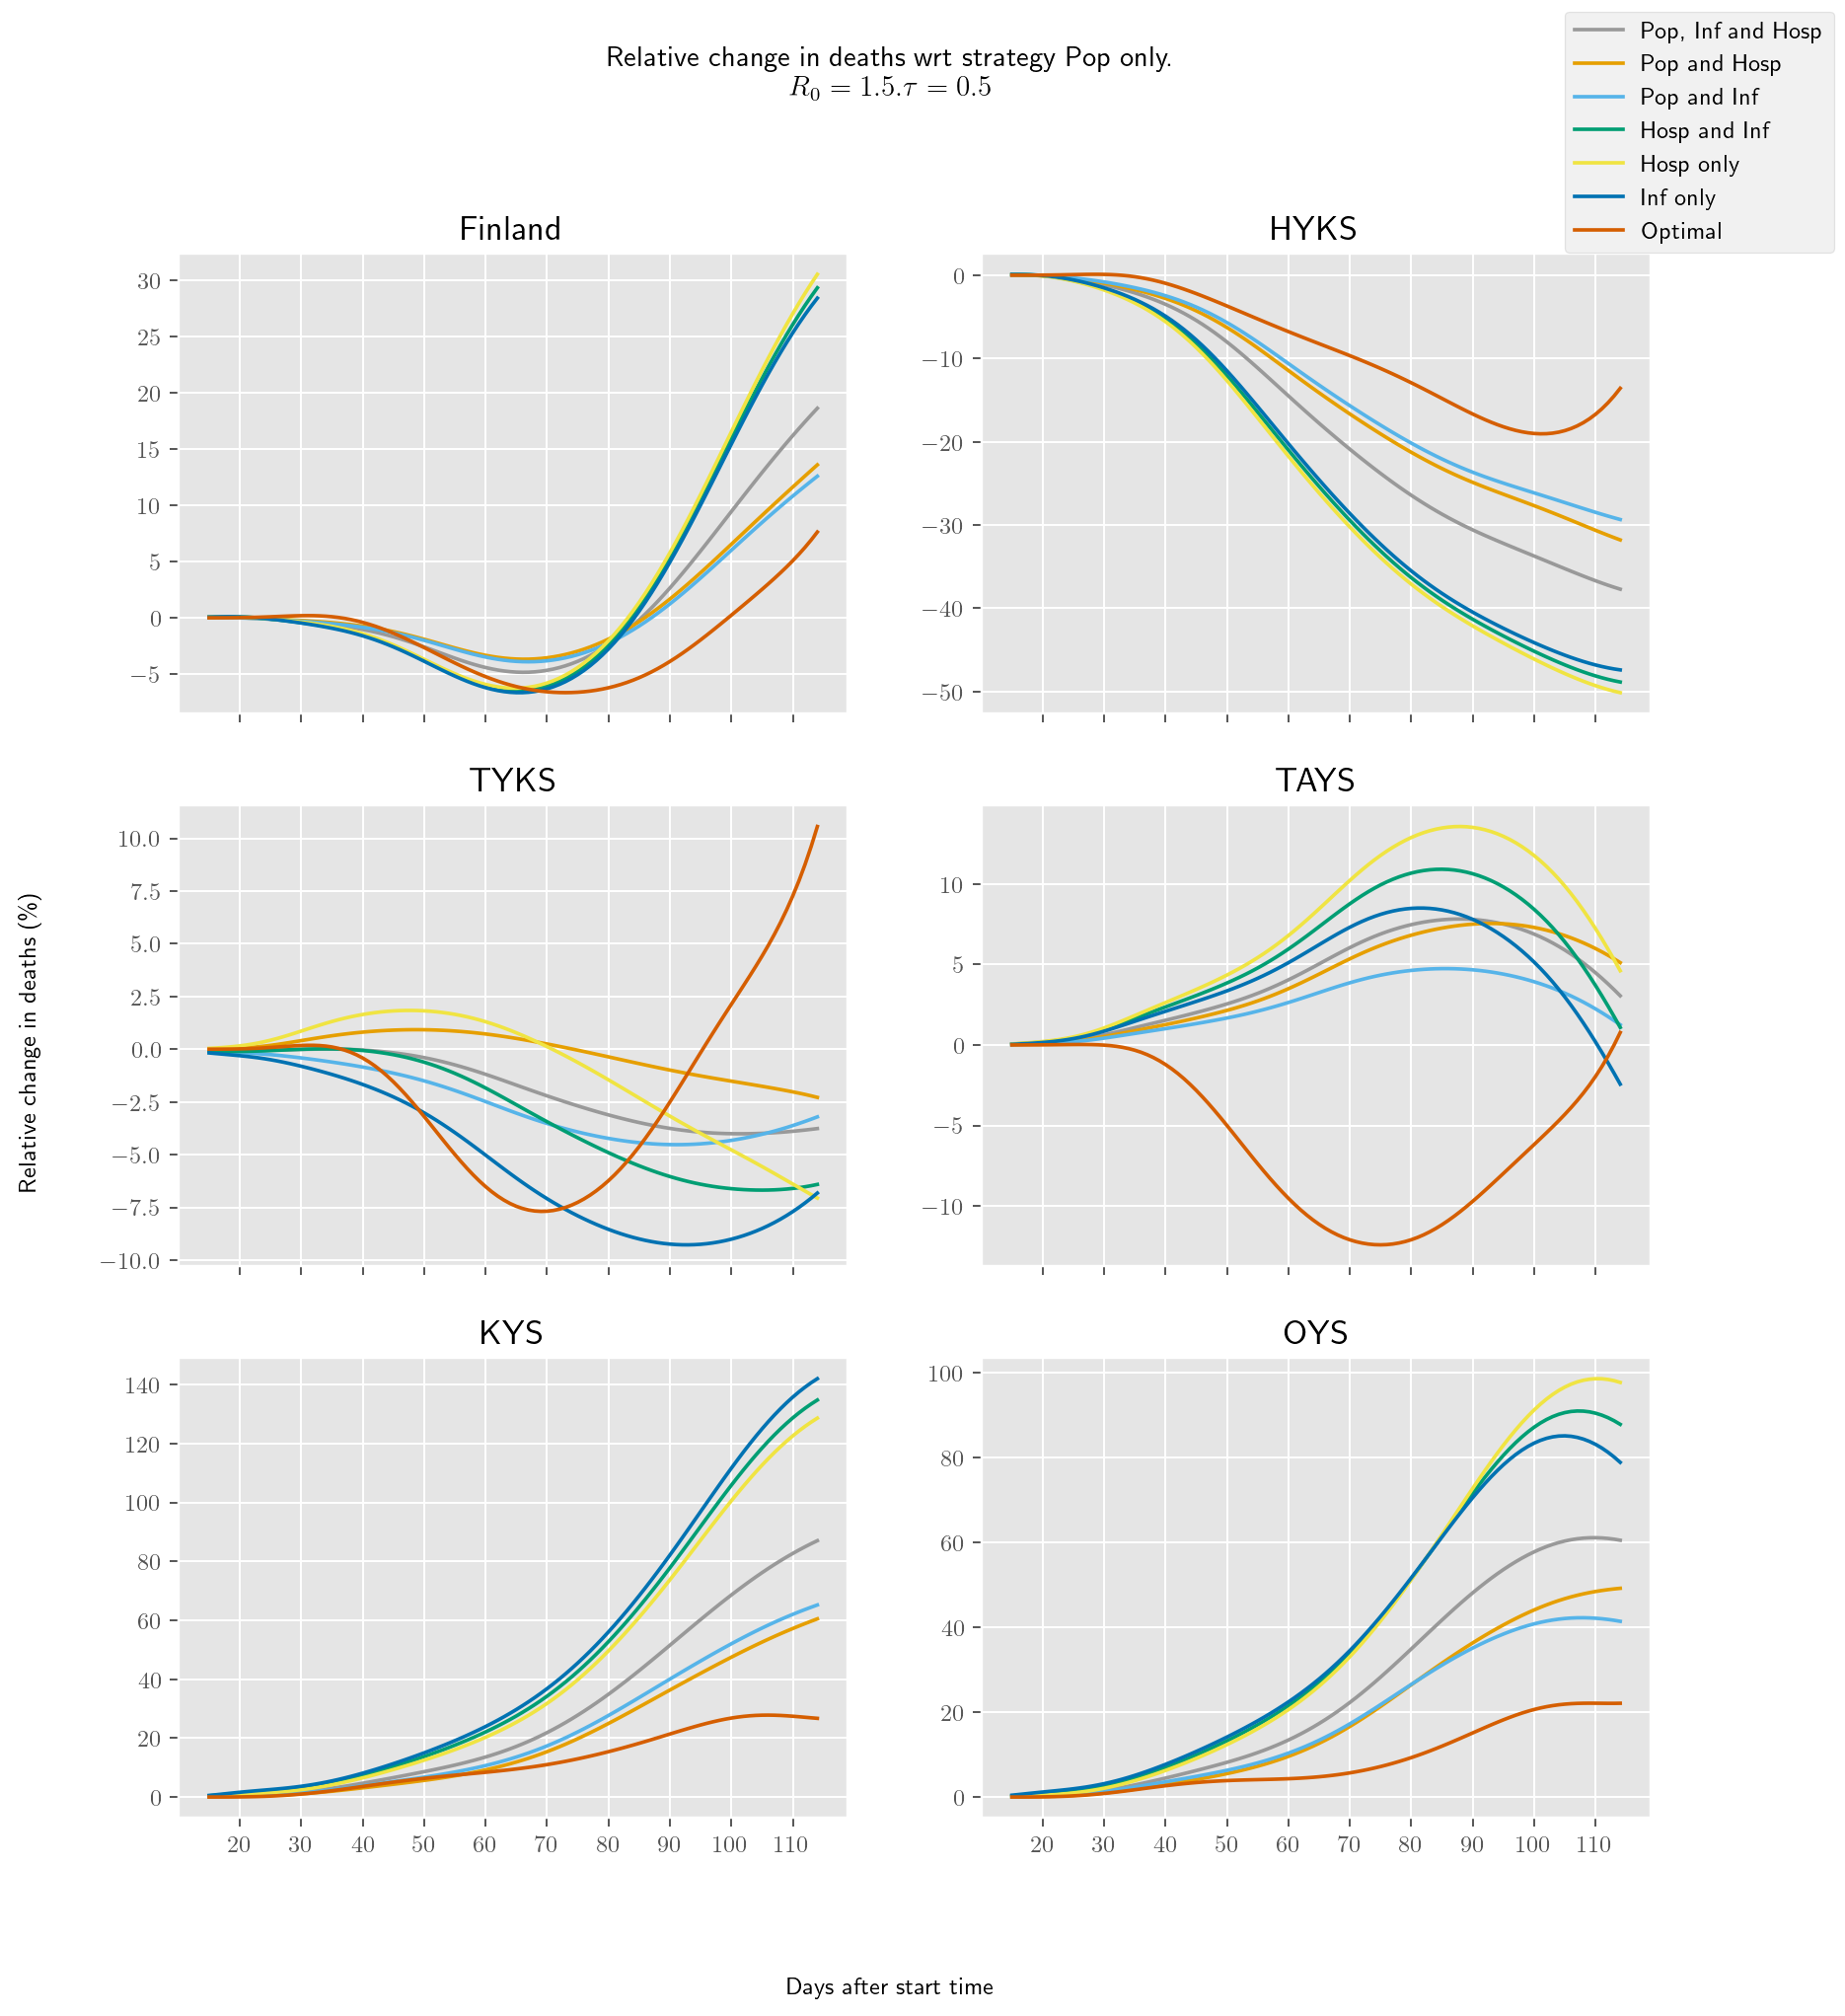

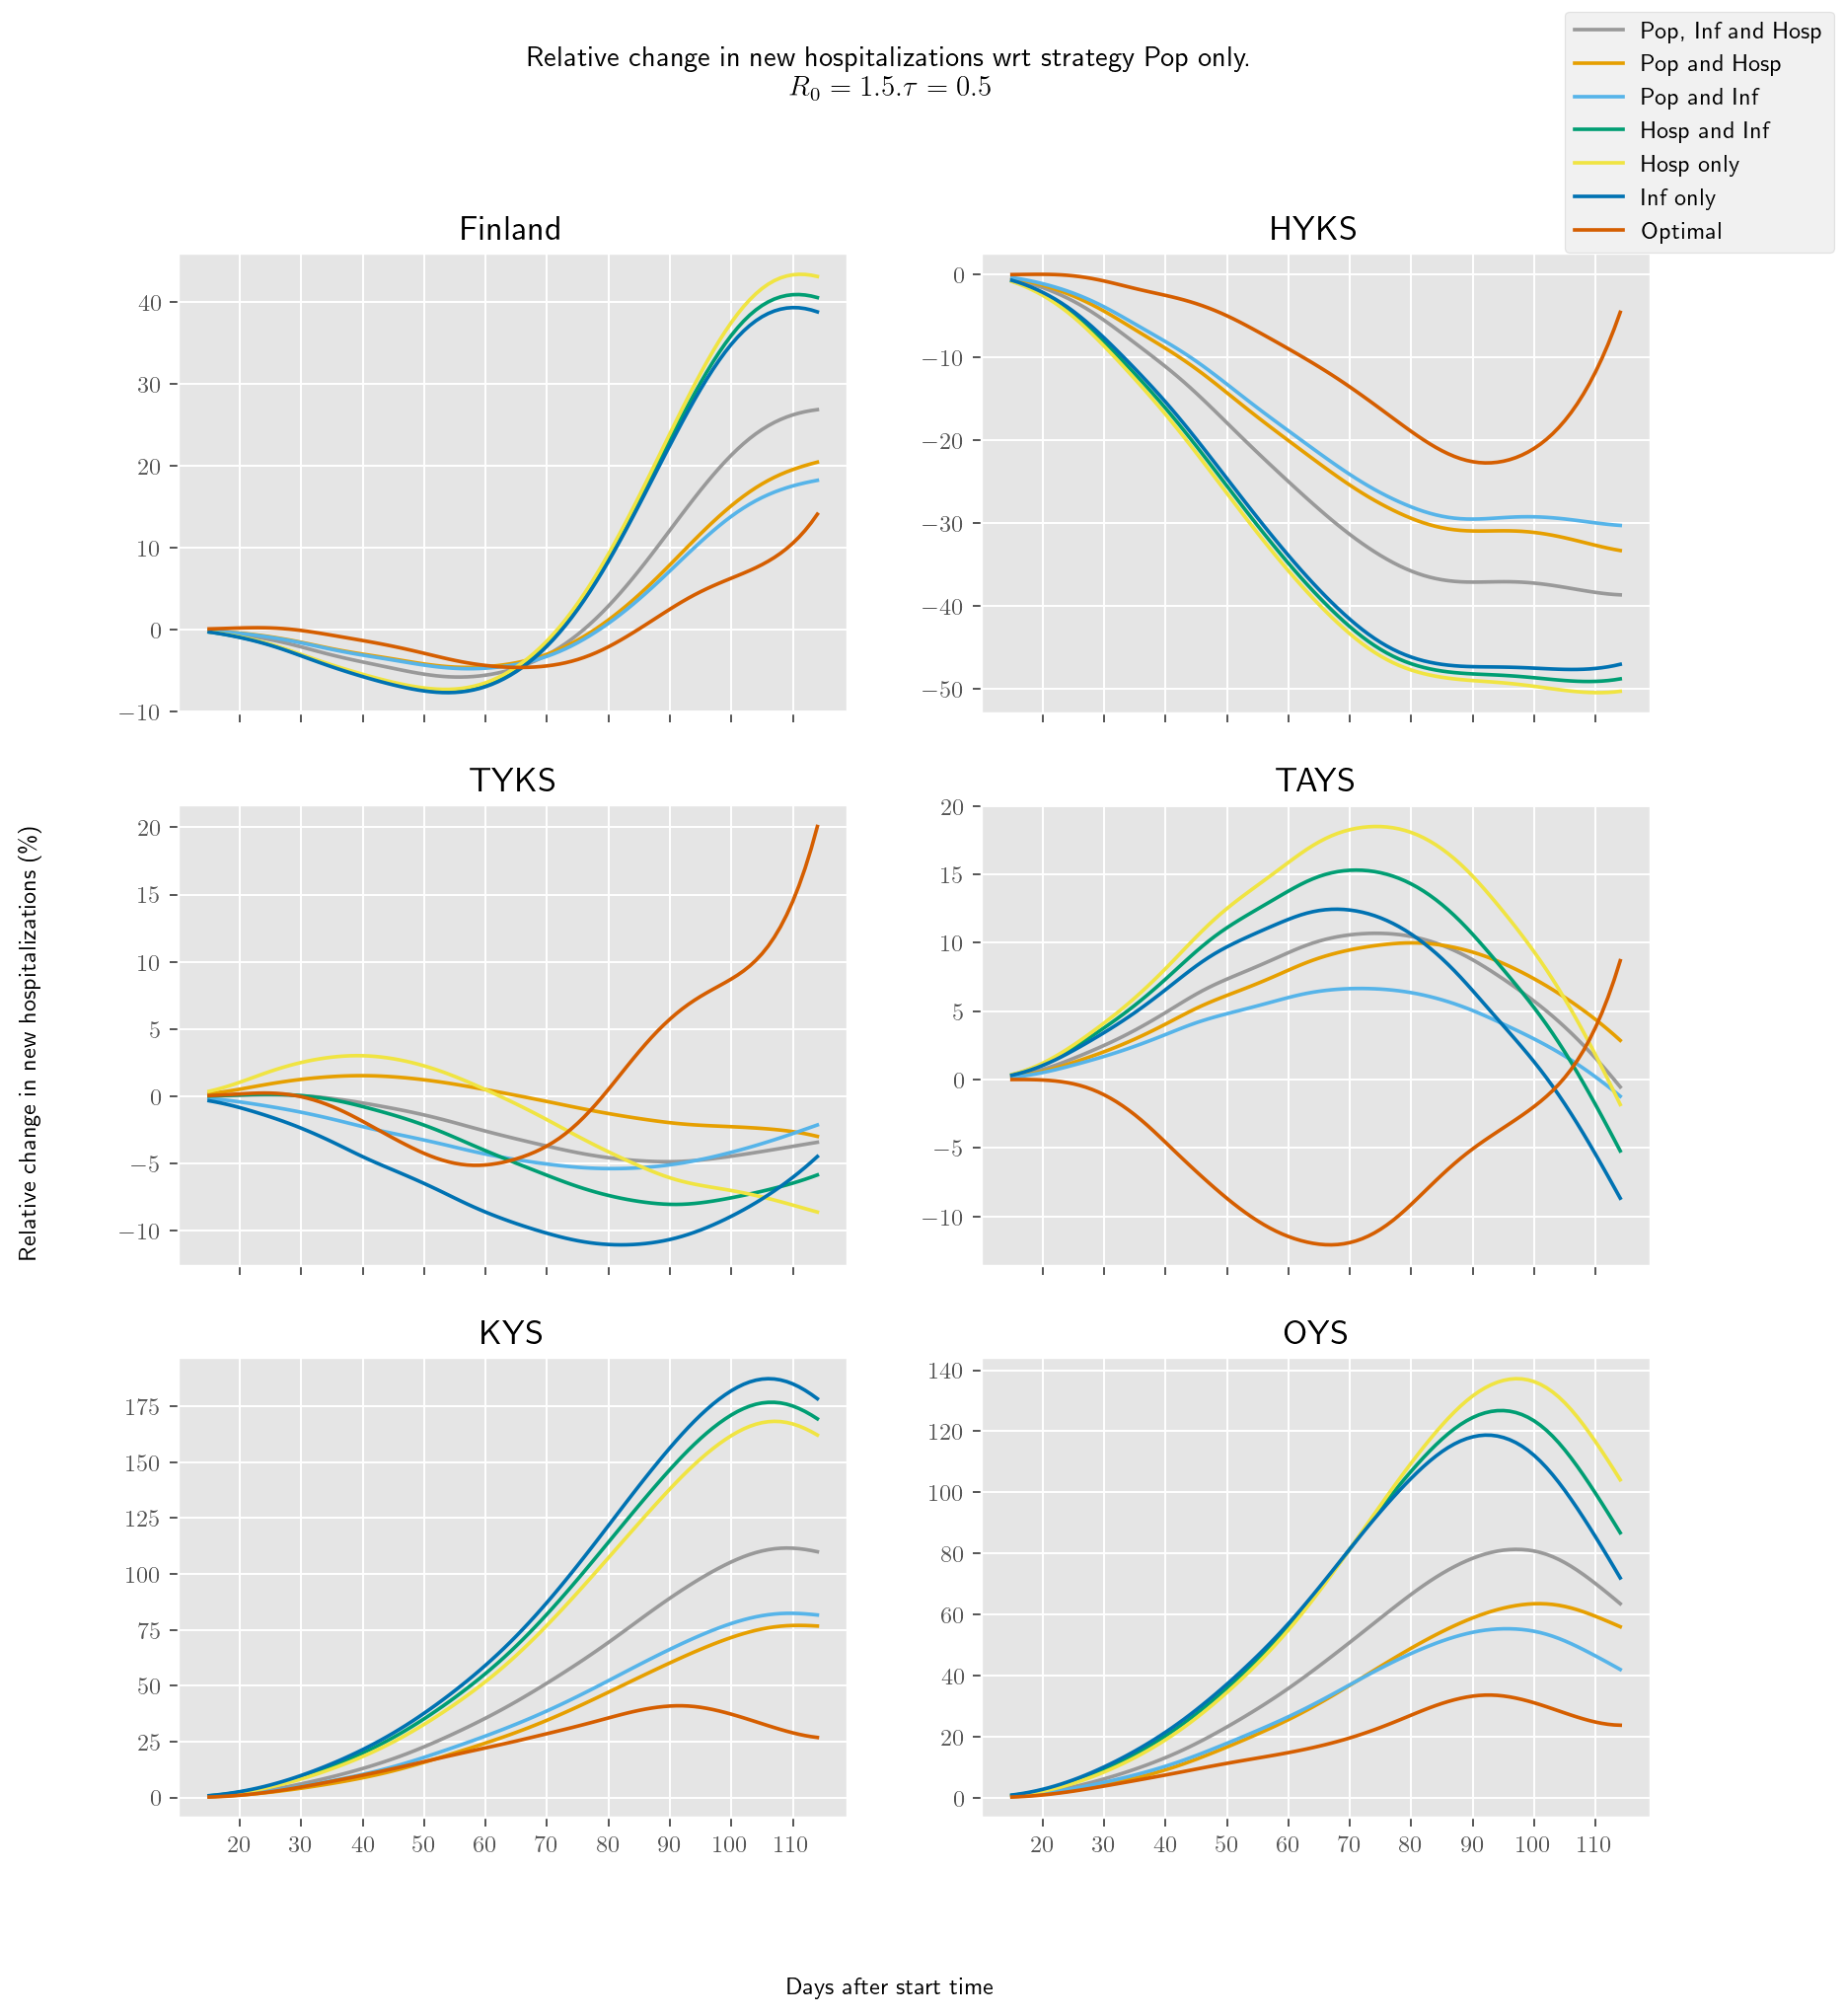

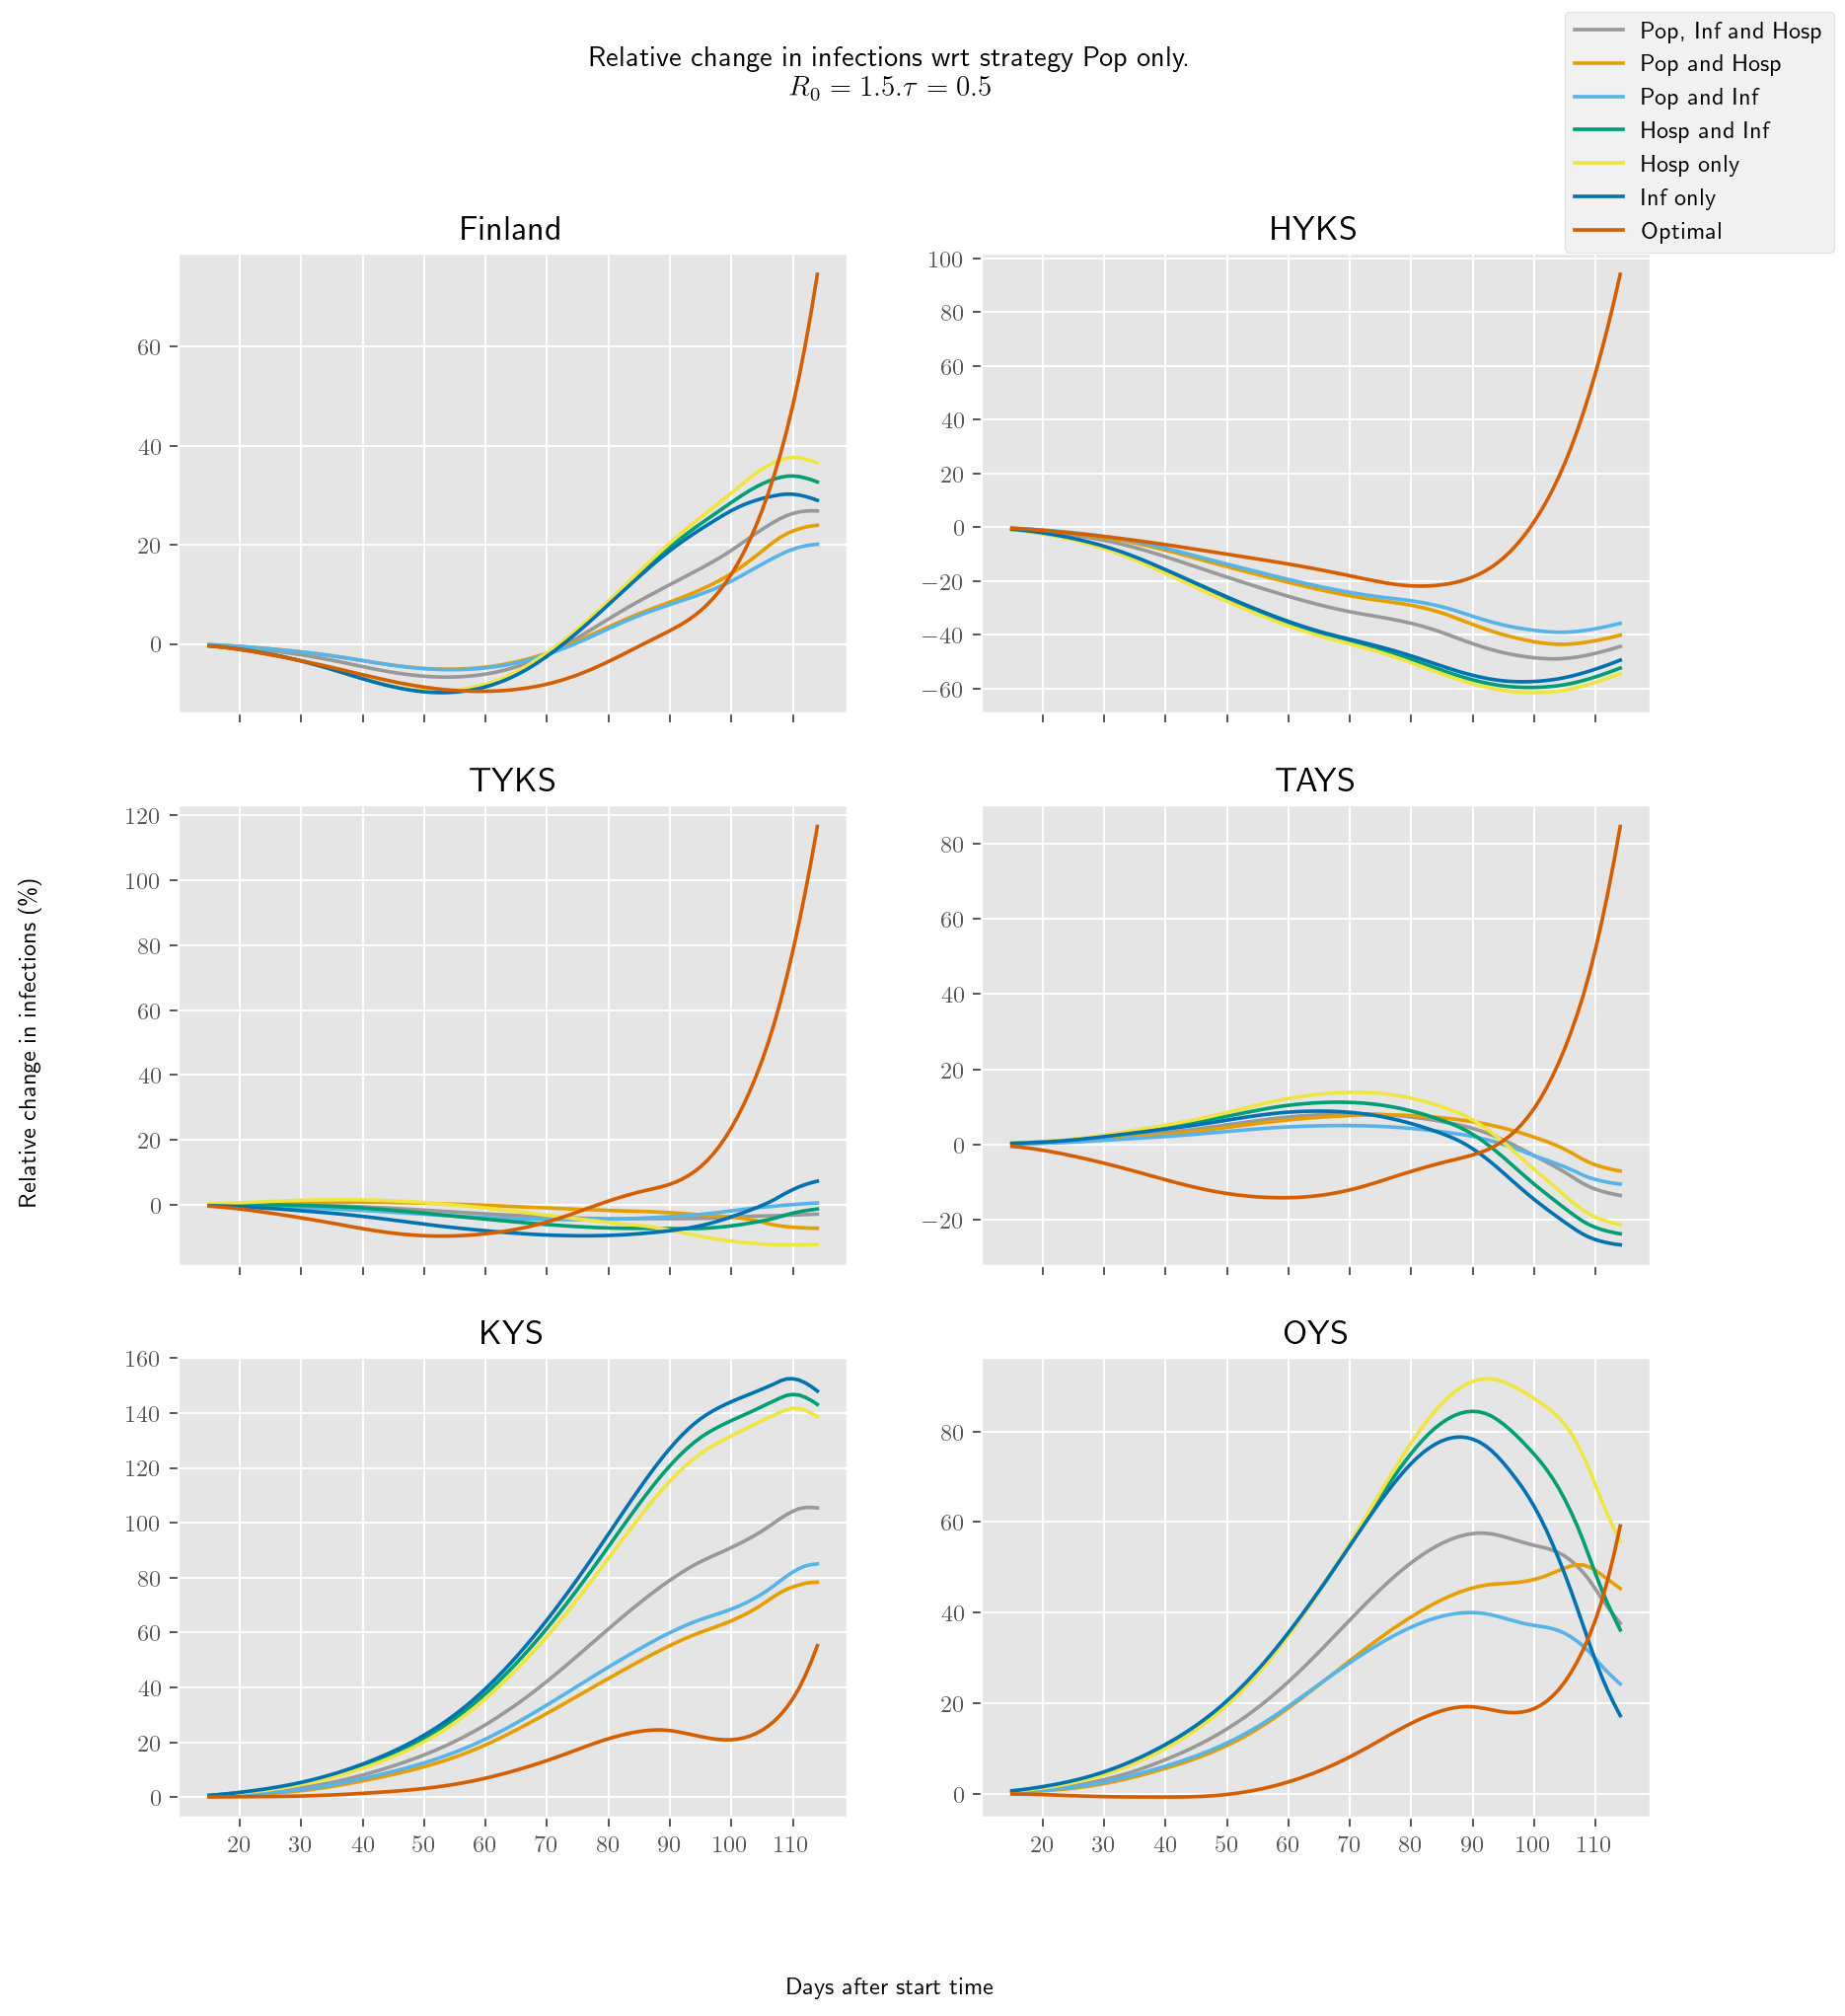

In [12]:
latex_template = """
    \\begin{{figure}}[p]
      \\centering
      \\includegraphics[width=\\textwidth]{{img/{fig_name}}}
      \\caption{{Relative change in {metric} for all vaccination strategies with respect to vaccination strategy {baseline}.
      For this scenario, the basic reproduction number $R_0 = {r}$ and the mobility value $\\tau = {tau}$.
      Upper left: Finland, upper right: HYKS, middle left: TYKS, middle right: TAYS, lower left: KYS, lower right: OYS.}}
      \\label{{fig:{name}}}
    \\end{{figure}}
"""
metrics = ['deaths', 'new hospitalizations', 'infections']
taus = [0.5]
save_and_generate_latex(r_experiments=r_experiments, taus=taus, ervas_labels=ervas_labels, metrics=metrics,
                        exp_results=exp_results, skip_no_vacc=True, offset=15, file_format='pdf',
                        long_title=False, T=T, img_dir=os.path.join('out', 'img'), latex_template=latex_template,
                        plot_interval=plot_interval, baseline='Pop only', out_sort=False, dpis=2000)